In [1]:
## custom
from utils import utils, vis
# from utils import poly_point_isect as bo   ##bentley-ottmann sweep line

import criteria as C
import quality as Q
from gd2 import GD2

## third party
import networkx as nx
import pandas as pd
from PIL import Image
from natsort import natsorted


## sys
import random
from glob import glob
import math
from collections import defaultdict
import itertools
import time
import pickle as pkl

## numeric
import numpy as np
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
import scipy.io as io

import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from IPython.display import set_matplotlib_formats
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
set_matplotlib_formats('retina')
%config InlineBackend.figure_format = 'retina'


## Trees

In [ ]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

print('start')

## choose one criterion
criterion = 'stress'
sample_sizes = [1,2,4,8,16,32,64,128,256,512]
# sample_sizes = [4,]
sample_sizes = sample_sizes[::-1]

criteria_weights = dict(
    stress=1,
    ideal_edge_length=0.1,
    neighborhood_preservation=1,
    crossings=0.9,
    crossing_angle_maximization=0.1,
    aspect_ratio=0.1,
    angular_resolution=0.1,
    vertex_resolution=0.1,
    gabriel=0.5,
)




for depth in tqdm(range(9,4,-1)):
    G = nx.balanced_tree(2,depth)
    graph_str = f'tree-2-{depth}'
    
# for side_length in tqdm([64,32,61,8,4,2,1]):
#     G = nx.grid_2d_graph(16,side_length)
#     graph_str = f'grid-16-{side_length}'




    # G = nx.hypercube_graph(4)
    # G = utils.load_spx_teaser()
    # G = nx.karate_club_graph()


    dfs = {}

    for sample_size in tqdm(sample_sizes):

        gd = GD2(G)

        result = gd.optimize(
            criteria_weights={criterion: criteria_weights[criterion]}, 
            sample_sizes={criterion: sample_size},
            evaluate={criterion},

            max_iter=int(1e9), 
            time_limit=1200, ##sec
            evaluate_interval=5000,
            
            vis_interval=-200000//20,
            clear_output=False,

            criteria_kwargs = dict(
                aspect_ratio=dict(target=[1,1]),
            ),
#         optimizer_kwargs = dict(mode='Adam', lr=0.005),
            optimizer_kwargs = dict(mode='SGD', lr=2),
            scheduler_kwargs = dict(verbose=True),
        )


        dfs[sample_size] = pd.DataFrame({
            'time': [x['time'] for x in result['qualities_by_time']], 
            criterion: [x['qualities'][criterion] for x in result['qualities_by_time']]
        })


        pos = gd.pos.detach().numpy()
        pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
        vis.plot(
            gd.G, pos_G,
            gd.loss_curve, 
            result['iter'], result['runtime'],
            edge=True, show=True, save=False
        )
        
    t = int(time.time())
    fn_out = f'analysis/sample_size/{graph_str}-t{t}.pkl'
    print(fn_out)
    with open(fn_out, 'wb') as f:
        pkl.dump(dfs, f)
    




start


## Plot

In [46]:
natsorted(glob('analysis/sample_size/tree*,pkl')) 

[]

In [48]:
fns = [
    fn for fn in natsorted(glob('analysis/sample_size/tree*.pkl')) 
    if int(fn.split('-t')[-1].split('.')[0]) >= 1635422621
]

# fns = [
#     fn for fn in natsorted(glob('analysis/sample_size/grid*.pkl')) 
#     if int(fn.split('-t')[-1].split('.')[0]) >= 1635422621
# ]

# fns = natsorted(glob('analysis/sample_size/tree*')) 
fns

['analysis/sample_size/tree-2-7-t1635447607.pkl',
 'analysis/sample_size/tree-2-8-t1635435143.pkl',
 'analysis/sample_size/tree-2-9-t1635422621.pkl']

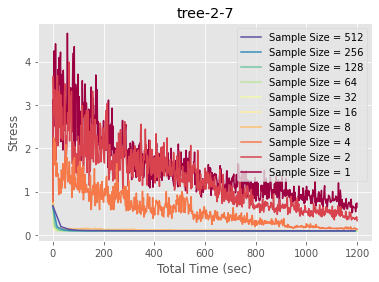

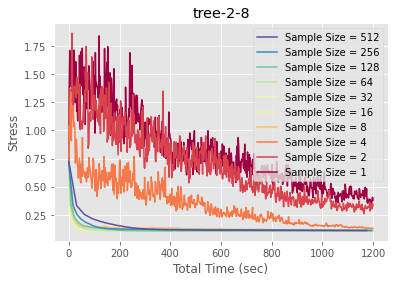

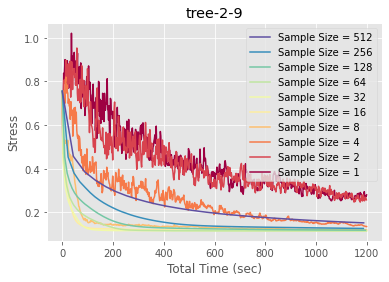

In [49]:
# cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('Spectral')


for fn_in in fns:
    graph_str = fn_in.split('/')[-1].split('-t')[0]
    with open(fn_in, 'rb') as f:
        dfs = pkl.load(f)
    criterion = next(iter(dfs.values())).columns[1]
    
    max_sample_size = max(dfs.keys())
    xmaxes = []
    for i, [sample_size, df] in enumerate(dfs.items()):
#         if sample_size <= 4: continue
        plt.plot(
            df['time'], df[criterion], 
            '-', 
            label=f'Sample Size = {sample_size}',
            color=cm(np.log(sample_size)/np.log(max_sample_size)),
            zorder=len(dfs)-i,
            lw=1.5,
    #         color=f'C{i}',
        )
        xmaxes.append(df['time'].iloc[-1])

    plt.xlabel('Total Time (sec)')
    plt.ylabel(utils.criterion_to_title(criterion))
    # plt.yscale('log')

#     plt.xlim([-1,sorted(xmaxes)[3]])
#     plt.xlim([-10,df['time'].iloc[-1]/5])
#     plt.xlim([-1,200])

#     plt.ylim([0,plt.ylim()[1]*1.05])
#     plt.ylim([-0.1,1])
    
    plt.legend()
    plt.title(graph_str)
#     plt.savefig(f'figures-tmp/analysis/sample-size/{graph_str}-t{t}.pdf', bbox_inches='tight')
    plt.show()



399.82730889320374

In [71]:
fn_in = f'analysis/sample_size/tree-2-8-t1634775611.pkl'
criterion = 'stress'
graph_str = 'tree-2-8'


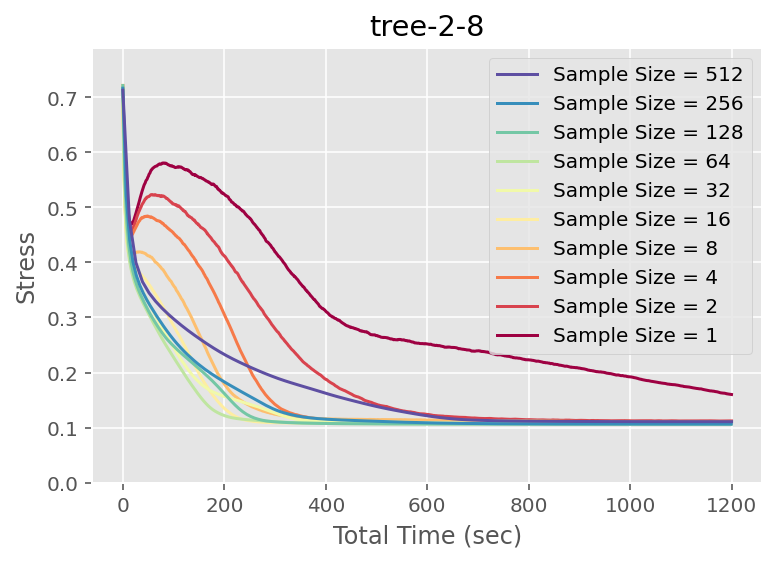

In [73]:
# cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('Spectral')
max_sample_size = max(dfs.keys())
xmaxes = []
for i, [sample_size, df] in enumerate(dfs.items()):
#     if sample_size < 32:
#         continue
        
    plt.plot(
        df['time'], df[criterion], 
        '-', 
#         alpha=0.6,
        label=f'Sample Size = {sample_size}',
        color=cm(np.log(sample_size)/np.log(max_sample_size)),
        zorder=len(dfs)-i,
        lw=1.5,
#         color=f'C{i}',
    )
    xmaxes.append(df['time'].iloc[-1])
    
plt.xlabel('Total Time (sec)')
plt.ylabel(utils.criterion_to_title(criterion))
# plt.yscale('log')

# plt.xlim([-1,sorted(xmaxes)[3]])
# plt.xlim([-1,200])
plt.ylim([0,plt.ylim()[1]*1.05])
plt.legend()
plt.title(graph_str)
plt.savefig(f'figures-tmp/analysis/sample-size/{graph_str}-t{t}.pdf', bbox_inches='tight')
plt.show()

# Old

127


Epoch  2650: reducing learning rate of group 0 to 4.5000e-01.
Epoch  4751: reducing learning rate of group 0 to 4.0500e-01.
Epoch  6852: reducing learning rate of group 0 to 3.6450e-01.
Epoch  8953: reducing learning rate of group 0 to 3.2805e-01.
Epoch 14774: reducing learning rate of group 0 to 2.9525e-01.
Epoch 17851: reducing learning rate of group 0 to 2.6572e-01.


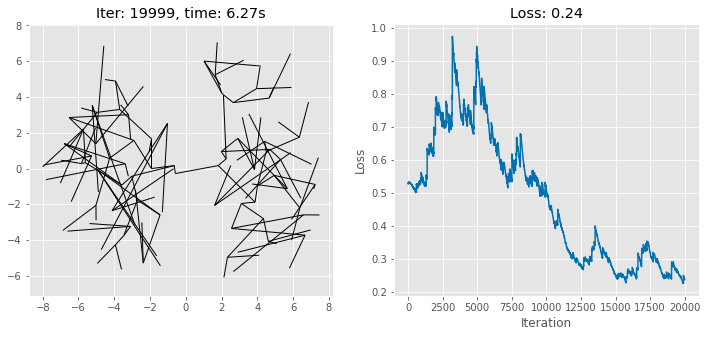

Epoch 31352: reducing learning rate of group 0 to 2.3915e-01.
Epoch 34404: reducing learning rate of group 0 to 2.1523e-01.
Epoch 36505: reducing learning rate of group 0 to 1.9371e-01.


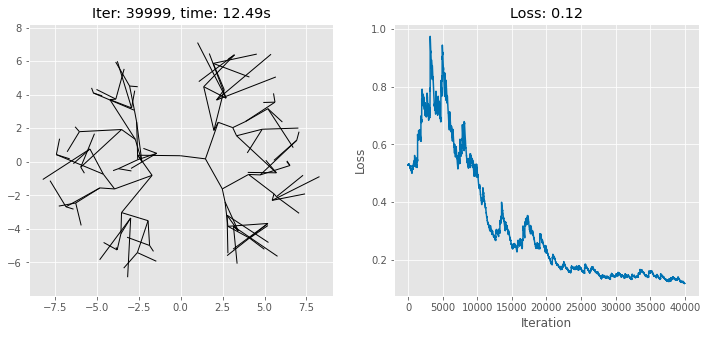

Epoch 47367: reducing learning rate of group 0 to 1.7434e-01.
Epoch 50688: reducing learning rate of group 0 to 1.5691e-01.
Epoch 53855: reducing learning rate of group 0 to 1.4121e-01.
Epoch 55956: reducing learning rate of group 0 to 1.2709e-01.
Epoch 58057: reducing learning rate of group 0 to 1.1438e-01.


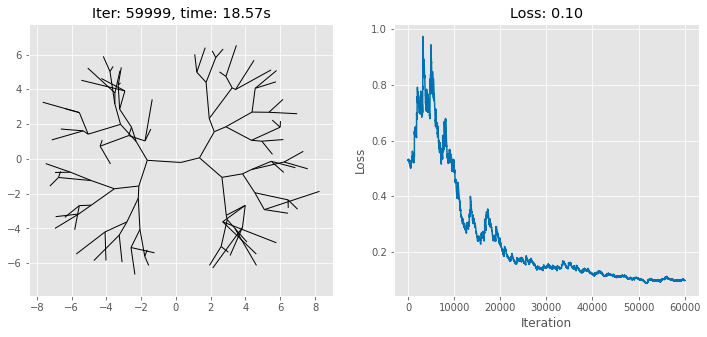

Epoch 60158: reducing learning rate of group 0 to 1.0295e-01.
Epoch 62259: reducing learning rate of group 0 to 9.2651e-02.
Epoch 64360: reducing learning rate of group 0 to 8.3386e-02.
Epoch 68430: reducing learning rate of group 0 to 7.5047e-02.
Epoch 70531: reducing learning rate of group 0 to 6.7543e-02.
Epoch 72632: reducing learning rate of group 0 to 6.0788e-02.
Epoch 74733: reducing learning rate of group 0 to 5.4709e-02.
Epoch 77609: reducing learning rate of group 0 to 4.9239e-02.
Epoch 79710: reducing learning rate of group 0 to 4.4315e-02.


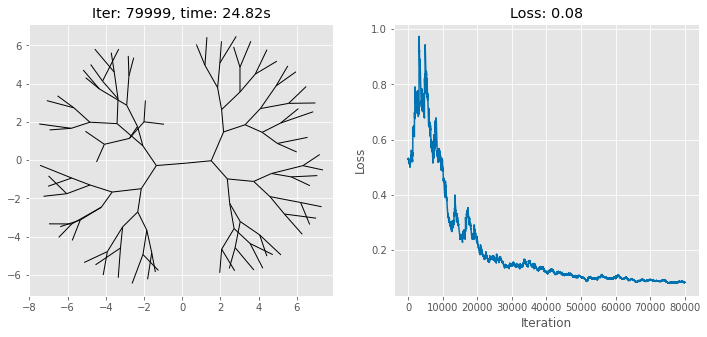

Epoch 81811: reducing learning rate of group 0 to 3.9883e-02.
Epoch 83912: reducing learning rate of group 0 to 3.5895e-02.
Epoch 86868: reducing learning rate of group 0 to 3.2305e-02.
Epoch 88969: reducing learning rate of group 0 to 2.9075e-02.
Epoch 91070: reducing learning rate of group 0 to 2.6167e-02.
Epoch 93171: reducing learning rate of group 0 to 2.3551e-02.
Epoch 95272: reducing learning rate of group 0 to 2.1196e-02.
Epoch 97373: reducing learning rate of group 0 to 1.9076e-02.
Epoch 99775: reducing learning rate of group 0 to 1.7168e-02.


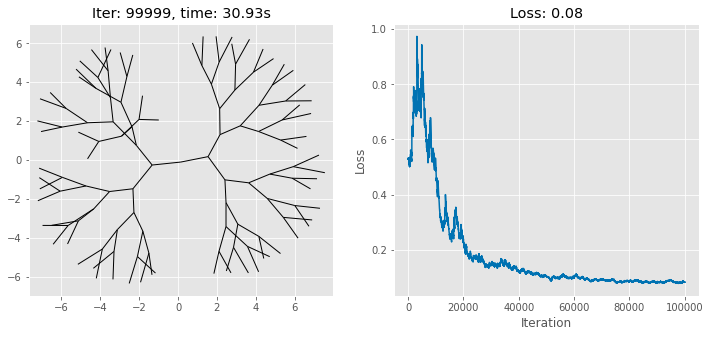

Epoch 101876: reducing learning rate of group 0 to 1.5452e-02.
Epoch 104266: reducing learning rate of group 0 to 1.3906e-02.
Epoch 106367: reducing learning rate of group 0 to 1.2516e-02.
Epoch 108468: reducing learning rate of group 0 to 1.1264e-02.
Epoch 110569: reducing learning rate of group 0 to 1.0138e-02.
Epoch 112670: reducing learning rate of group 0 to 9.1240e-03.
Epoch 114771: reducing learning rate of group 0 to 8.2116e-03.
Epoch 116872: reducing learning rate of group 0 to 7.3904e-03.
Epoch 118973: reducing learning rate of group 0 to 6.6514e-03.


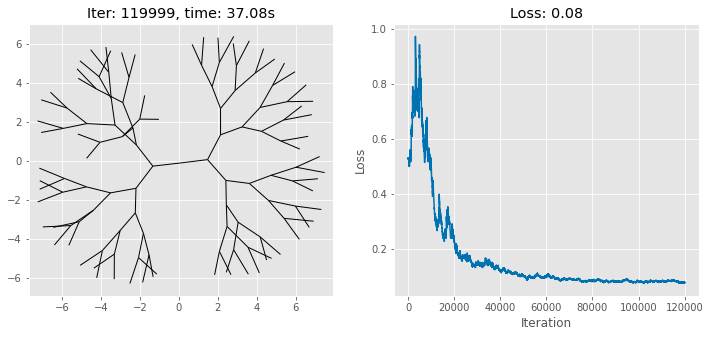

Epoch 121074: reducing learning rate of group 0 to 5.9863e-03.
Epoch 123175: reducing learning rate of group 0 to 5.3876e-03.
Epoch 125276: reducing learning rate of group 0 to 4.8489e-03.
Epoch 127377: reducing learning rate of group 0 to 4.3640e-03.
Epoch 129478: reducing learning rate of group 0 to 3.9276e-03.
Epoch 133279: reducing learning rate of group 0 to 3.5348e-03.
Epoch 137122: reducing learning rate of group 0 to 3.1813e-03.
Epoch 139223: reducing learning rate of group 0 to 2.8632e-03.


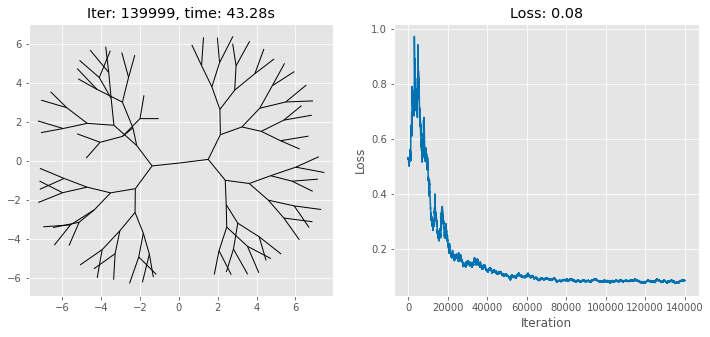

Epoch 141324: reducing learning rate of group 0 to 2.5769e-03.
Epoch 143425: reducing learning rate of group 0 to 2.3192e-03.
Epoch 145526: reducing learning rate of group 0 to 2.0873e-03.
Epoch 149008: reducing learning rate of group 0 to 1.8786e-03.
Epoch 151109: reducing learning rate of group 0 to 1.6907e-03.
Epoch 153210: reducing learning rate of group 0 to 1.5216e-03.
Epoch 155311: reducing learning rate of group 0 to 1.3695e-03.
Epoch 157412: reducing learning rate of group 0 to 1.2325e-03.
Epoch 159513: reducing learning rate of group 0 to 1.1093e-03.


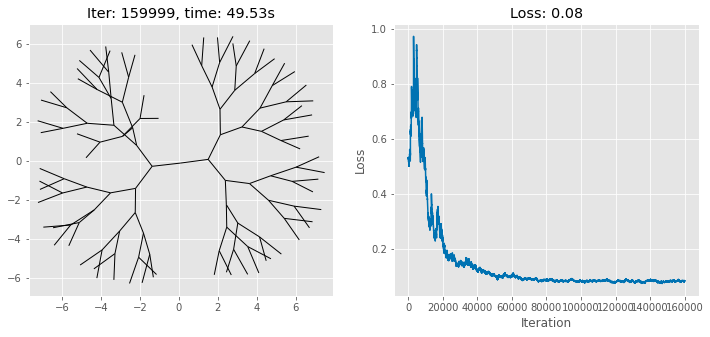

Epoch 161614: reducing learning rate of group 0 to 9.9834e-04.
Epoch 163715: reducing learning rate of group 0 to 8.9851e-04.
Epoch 165816: reducing learning rate of group 0 to 8.0865e-04.
Epoch 167917: reducing learning rate of group 0 to 7.2779e-04.
Epoch 170018: reducing learning rate of group 0 to 6.5501e-04.
Epoch 172119: reducing learning rate of group 0 to 5.8951e-04.
Epoch 176124: reducing learning rate of group 0 to 5.3056e-04.
Epoch 178225: reducing learning rate of group 0 to 4.7750e-04.


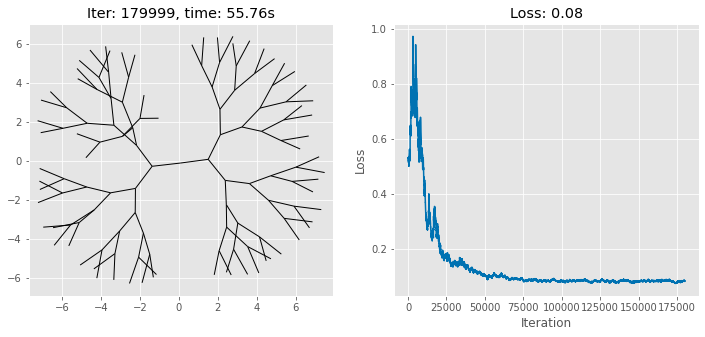

Epoch 180326: reducing learning rate of group 0 to 4.2975e-04.
Epoch 182427: reducing learning rate of group 0 to 3.8678e-04.
Epoch 186302: reducing learning rate of group 0 to 3.4810e-04.
Epoch 188403: reducing learning rate of group 0 to 3.1329e-04.
Epoch 190504: reducing learning rate of group 0 to 2.8196e-04.
Epoch 192605: reducing learning rate of group 0 to 2.5376e-04.
Epoch 194706: reducing learning rate of group 0 to 2.2839e-04.
Epoch 196807: reducing learning rate of group 0 to 2.0555e-04.
Epoch 198908: reducing learning rate of group 0 to 1.8499e-04.


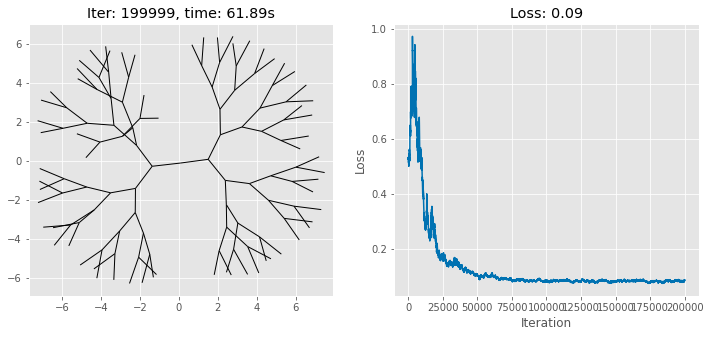

Epoch 201009: reducing learning rate of group 0 to 1.6649e-04.
Epoch 203110: reducing learning rate of group 0 to 1.4985e-04.
Epoch 205211: reducing learning rate of group 0 to 1.3486e-04.
Epoch 207312: reducing learning rate of group 0 to 1.2137e-04.
Epoch 209413: reducing learning rate of group 0 to 1.0924e-04.
Epoch 211514: reducing learning rate of group 0 to 9.8314e-05.
Epoch 213615: reducing learning rate of group 0 to 8.8482e-05.
Epoch 215716: reducing learning rate of group 0 to 7.9634e-05.
Epoch 217817: reducing learning rate of group 0 to 7.1671e-05.
Epoch 219918: reducing learning rate of group 0 to 6.4504e-05.


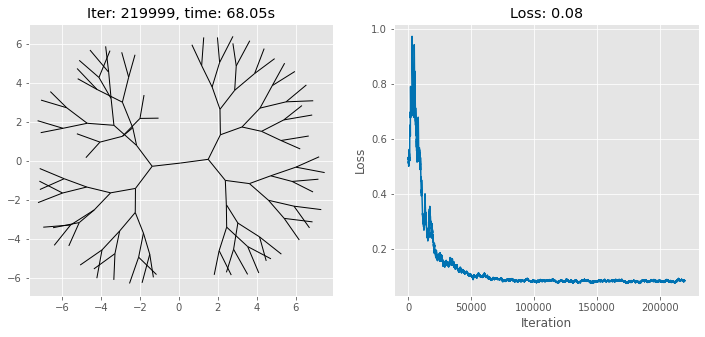

Epoch 222019: reducing learning rate of group 0 to 5.8053e-05.
Epoch 224120: reducing learning rate of group 0 to 5.2248e-05.
Epoch 226221: reducing learning rate of group 0 to 4.7023e-05.
Epoch 228322: reducing learning rate of group 0 to 4.2321e-05.
Epoch 230423: reducing learning rate of group 0 to 3.8089e-05.
Epoch 232524: reducing learning rate of group 0 to 3.4280e-05.
Epoch 234625: reducing learning rate of group 0 to 3.0852e-05.
Epoch 236726: reducing learning rate of group 0 to 2.7767e-05.
Epoch 238827: reducing learning rate of group 0 to 2.4990e-05.


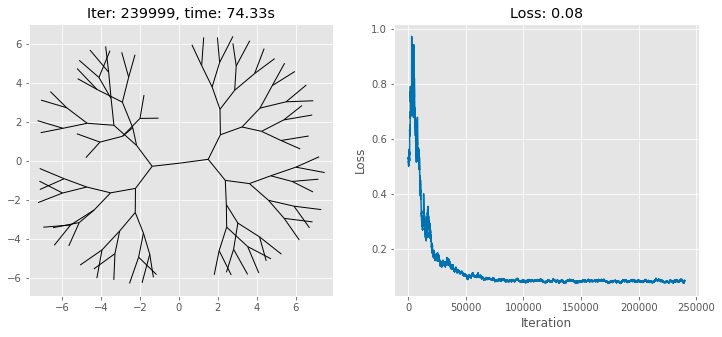

Epoch 240928: reducing learning rate of group 0 to 2.2491e-05.
Epoch 243029: reducing learning rate of group 0 to 2.0242e-05.
Epoch 245130: reducing learning rate of group 0 to 1.8218e-05.
Epoch 247231: reducing learning rate of group 0 to 1.6396e-05.
Epoch 249332: reducing learning rate of group 0 to 1.4756e-05.
Epoch 251433: reducing learning rate of group 0 to 1.3281e-05.
Epoch 253534: reducing learning rate of group 0 to 1.1953e-05.
Epoch 255635: reducing learning rate of group 0 to 1.0757e-05.
Epoch 257736: reducing learning rate of group 0 to 1.0000e-05.



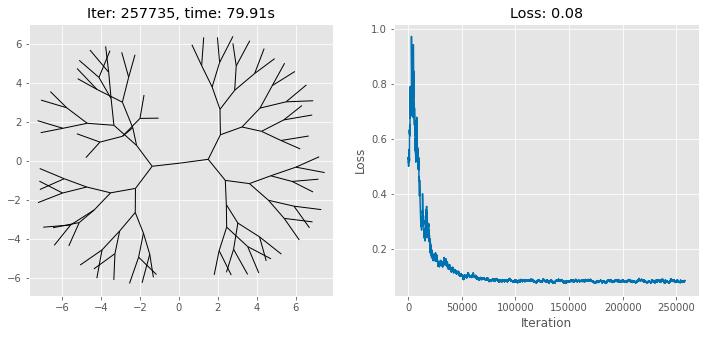

127


Epoch  4592: reducing learning rate of group 0 to 4.5000e-01.
Epoch  6693: reducing learning rate of group 0 to 4.0500e-01.


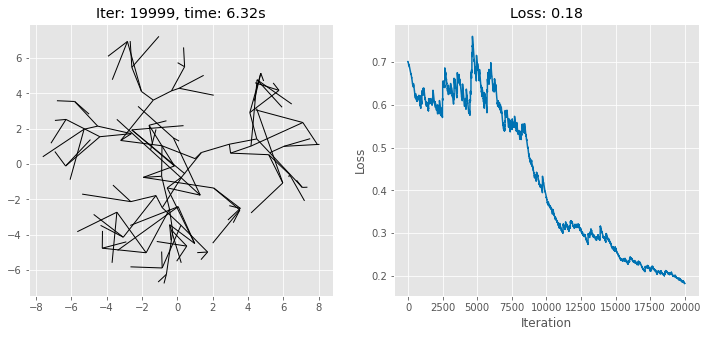

Epoch 32733: reducing learning rate of group 0 to 3.6450e-01.
Epoch 36884: reducing learning rate of group 0 to 3.2805e-01.


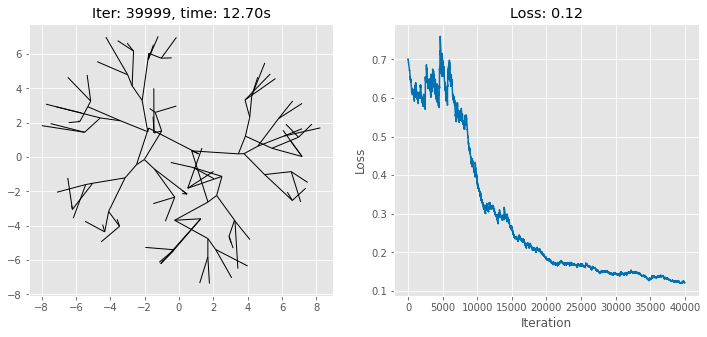

Epoch 43885: reducing learning rate of group 0 to 2.9525e-01.
Epoch 48669: reducing learning rate of group 0 to 2.6572e-01.
Epoch 54891: reducing learning rate of group 0 to 2.3915e-01.
Epoch 56992: reducing learning rate of group 0 to 2.1523e-01.


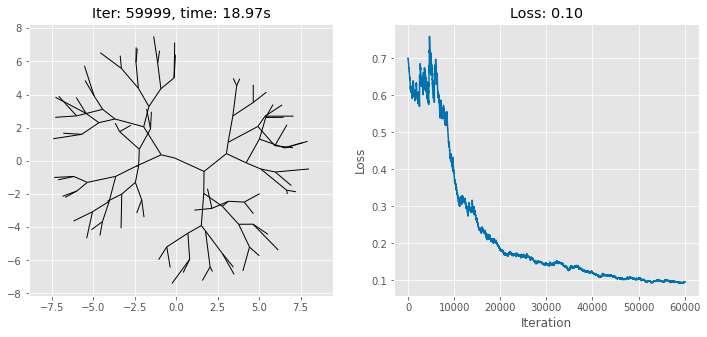

Epoch 65834: reducing learning rate of group 0 to 1.9371e-01.
Epoch 68852: reducing learning rate of group 0 to 1.7434e-01.
Epoch 72231: reducing learning rate of group 0 to 1.5691e-01.


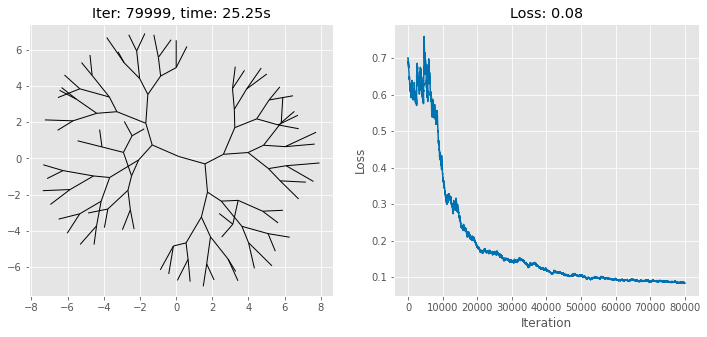

Epoch 84140: reducing learning rate of group 0 to 1.4121e-01.
Epoch 86241: reducing learning rate of group 0 to 1.2709e-01.
Epoch 88342: reducing learning rate of group 0 to 1.1438e-01.
Epoch 90443: reducing learning rate of group 0 to 1.0295e-01.
Epoch 92544: reducing learning rate of group 0 to 9.2651e-02.
Epoch 95594: reducing learning rate of group 0 to 8.3386e-02.
Epoch 97695: reducing learning rate of group 0 to 7.5047e-02.
Epoch 99796: reducing learning rate of group 0 to 6.7543e-02.


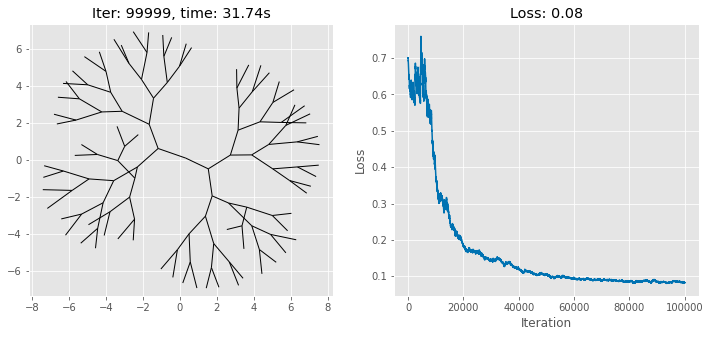

Epoch 104089: reducing learning rate of group 0 to 6.0788e-02.
Epoch 106190: reducing learning rate of group 0 to 5.4709e-02.
Epoch 108291: reducing learning rate of group 0 to 4.9239e-02.
Epoch 110392: reducing learning rate of group 0 to 4.4315e-02.
Epoch 112493: reducing learning rate of group 0 to 3.9883e-02.
Epoch 114594: reducing learning rate of group 0 to 3.5895e-02.
Epoch 116695: reducing learning rate of group 0 to 3.2305e-02.
Epoch 118796: reducing learning rate of group 0 to 2.9075e-02.


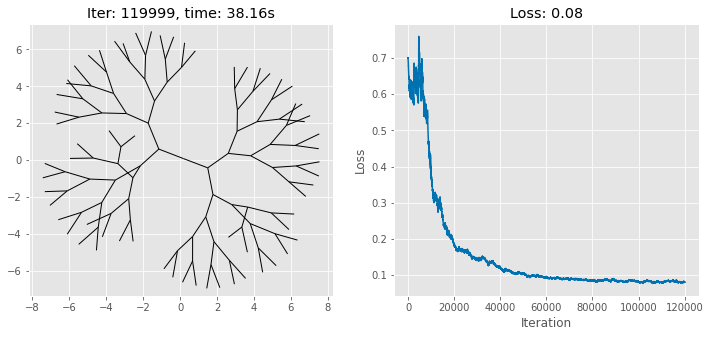

Epoch 120897: reducing learning rate of group 0 to 2.6167e-02.
Epoch 122998: reducing learning rate of group 0 to 2.3551e-02.
Epoch 125099: reducing learning rate of group 0 to 2.1196e-02.
Epoch 127200: reducing learning rate of group 0 to 1.9076e-02.
Epoch 129301: reducing learning rate of group 0 to 1.7168e-02.
Epoch 131402: reducing learning rate of group 0 to 1.5452e-02.
Epoch 135178: reducing learning rate of group 0 to 1.3906e-02.
Epoch 137279: reducing learning rate of group 0 to 1.2516e-02.
Epoch 139380: reducing learning rate of group 0 to 1.1264e-02.


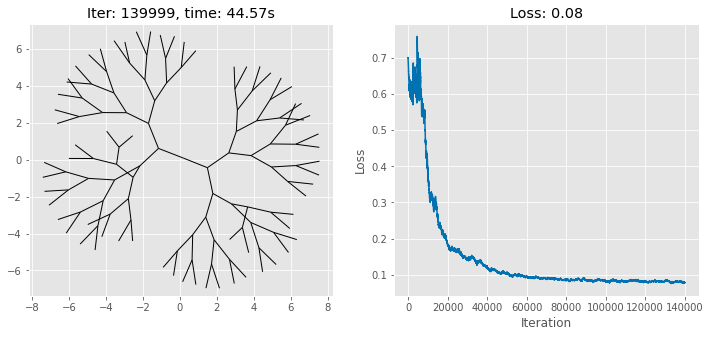

Epoch 141481: reducing learning rate of group 0 to 1.0138e-02.
Epoch 143582: reducing learning rate of group 0 to 9.1240e-03.
Epoch 145683: reducing learning rate of group 0 to 8.2116e-03.
Epoch 147784: reducing learning rate of group 0 to 7.3904e-03.
Epoch 149885: reducing learning rate of group 0 to 6.6514e-03.
Epoch 151986: reducing learning rate of group 0 to 5.9863e-03.
Epoch 154087: reducing learning rate of group 0 to 5.3876e-03.
Epoch 156570: reducing learning rate of group 0 to 4.8489e-03.
Epoch 158671: reducing learning rate of group 0 to 4.3640e-03.


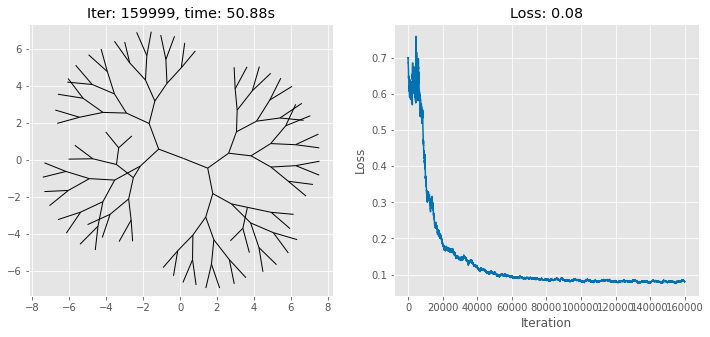

Epoch 160772: reducing learning rate of group 0 to 3.9276e-03.
Epoch 162873: reducing learning rate of group 0 to 3.5348e-03.
Epoch 164974: reducing learning rate of group 0 to 3.1813e-03.
Epoch 167075: reducing learning rate of group 0 to 2.8632e-03.
Epoch 169176: reducing learning rate of group 0 to 2.5769e-03.
Epoch 171277: reducing learning rate of group 0 to 2.3192e-03.
Epoch 174329: reducing learning rate of group 0 to 2.0873e-03.
Epoch 176430: reducing learning rate of group 0 to 1.8786e-03.
Epoch 178531: reducing learning rate of group 0 to 1.6907e-03.


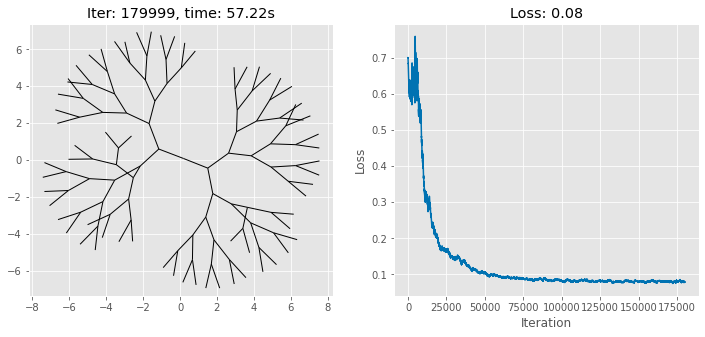

Epoch 180632: reducing learning rate of group 0 to 1.5216e-03.
Epoch 182733: reducing learning rate of group 0 to 1.3695e-03.
Epoch 184834: reducing learning rate of group 0 to 1.2325e-03.
Epoch 186935: reducing learning rate of group 0 to 1.1093e-03.
Epoch 189036: reducing learning rate of group 0 to 9.9834e-04.
Epoch 191137: reducing learning rate of group 0 to 8.9851e-04.
Epoch 193238: reducing learning rate of group 0 to 8.0865e-04.
Epoch 195339: reducing learning rate of group 0 to 7.2779e-04.
Epoch 197440: reducing learning rate of group 0 to 6.5501e-04.
Epoch 199541: reducing learning rate of group 0 to 5.8951e-04.


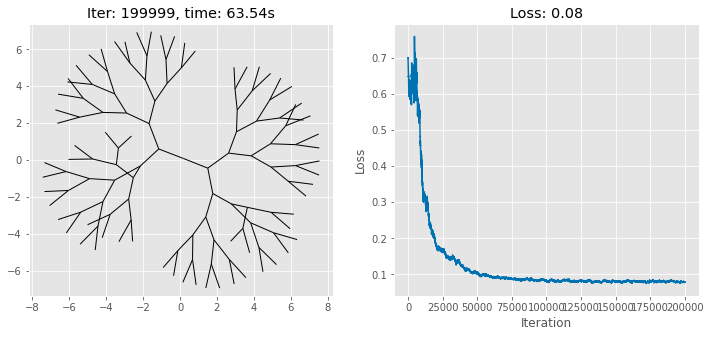

Epoch 201642: reducing learning rate of group 0 to 5.3056e-04.
Epoch 203743: reducing learning rate of group 0 to 4.7750e-04.
Epoch 205844: reducing learning rate of group 0 to 4.2975e-04.
Epoch 207945: reducing learning rate of group 0 to 3.8678e-04.
Epoch 210046: reducing learning rate of group 0 to 3.4810e-04.
Epoch 212147: reducing learning rate of group 0 to 3.1329e-04.
Epoch 214248: reducing learning rate of group 0 to 2.8196e-04.
Epoch 216349: reducing learning rate of group 0 to 2.5376e-04.
Epoch 218450: reducing learning rate of group 0 to 2.2839e-04.


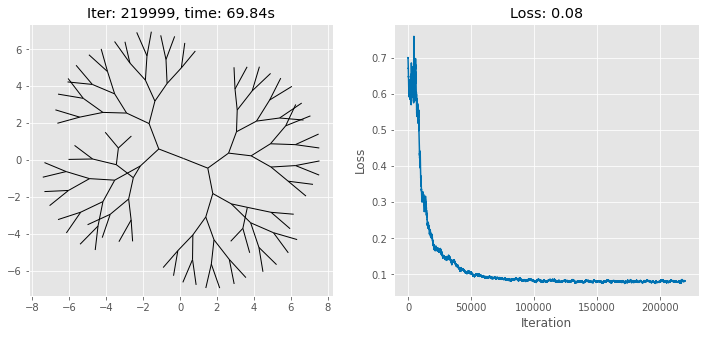

Epoch 220551: reducing learning rate of group 0 to 2.0555e-04.
Epoch 222652: reducing learning rate of group 0 to 1.8499e-04.
Epoch 224753: reducing learning rate of group 0 to 1.6649e-04.
Epoch 226854: reducing learning rate of group 0 to 1.4985e-04.
Epoch 228955: reducing learning rate of group 0 to 1.3486e-04.
Epoch 231056: reducing learning rate of group 0 to 1.2137e-04.
Epoch 233157: reducing learning rate of group 0 to 1.0924e-04.
Epoch 235258: reducing learning rate of group 0 to 9.8314e-05.
Epoch 237359: reducing learning rate of group 0 to 8.8482e-05.
Epoch 239460: reducing learning rate of group 0 to 7.9634e-05.


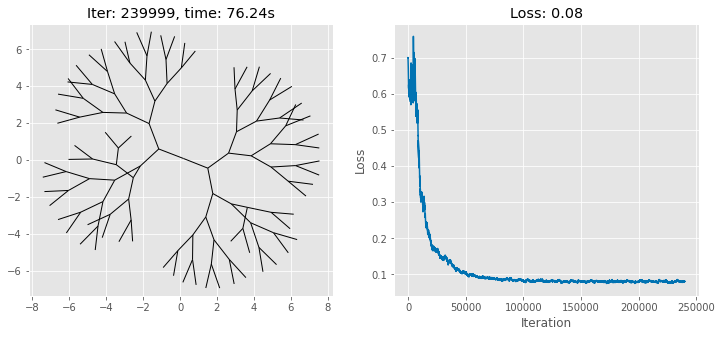

Epoch 241561: reducing learning rate of group 0 to 7.1671e-05.
Epoch 243662: reducing learning rate of group 0 to 6.4504e-05.
Epoch 245763: reducing learning rate of group 0 to 5.8053e-05.
Epoch 247864: reducing learning rate of group 0 to 5.2248e-05.
Epoch 250372: reducing learning rate of group 0 to 4.7023e-05.
Epoch 252473: reducing learning rate of group 0 to 4.2321e-05.
Epoch 254574: reducing learning rate of group 0 to 3.8089e-05.
Epoch 256675: reducing learning rate of group 0 to 3.4280e-05.
Epoch 258776: reducing learning rate of group 0 to 3.0852e-05.


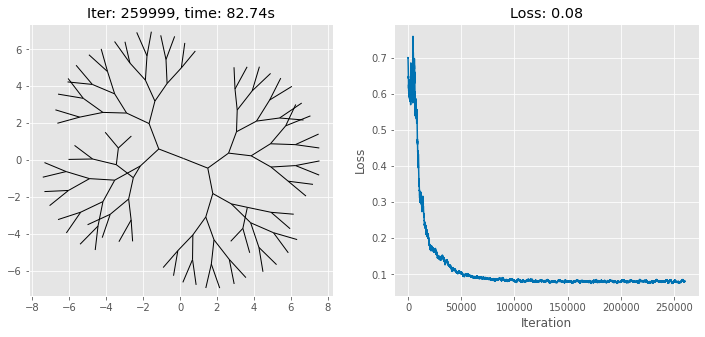

Epoch 260877: reducing learning rate of group 0 to 2.7767e-05.
Epoch 262978: reducing learning rate of group 0 to 2.4990e-05.
Epoch 265079: reducing learning rate of group 0 to 2.2491e-05.
Epoch 267180: reducing learning rate of group 0 to 2.0242e-05.
Epoch 269281: reducing learning rate of group 0 to 1.8218e-05.
Epoch 271382: reducing learning rate of group 0 to 1.6396e-05.
Epoch 273483: reducing learning rate of group 0 to 1.4756e-05.
Epoch 275584: reducing learning rate of group 0 to 1.3281e-05.
Epoch 277685: reducing learning rate of group 0 to 1.1953e-05.
Epoch 279786: reducing learning rate of group 0 to 1.0757e-05.


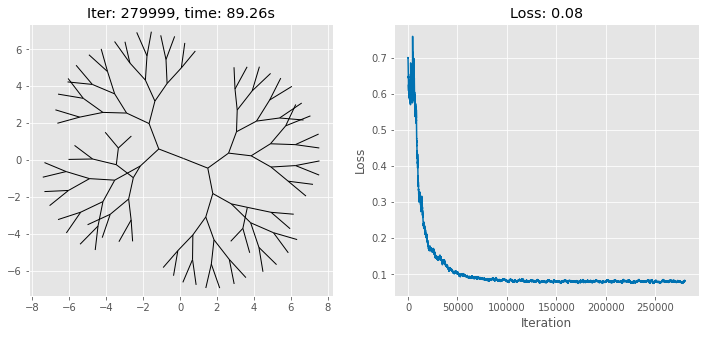

Epoch 281887: reducing learning rate of group 0 to 1.0000e-05.



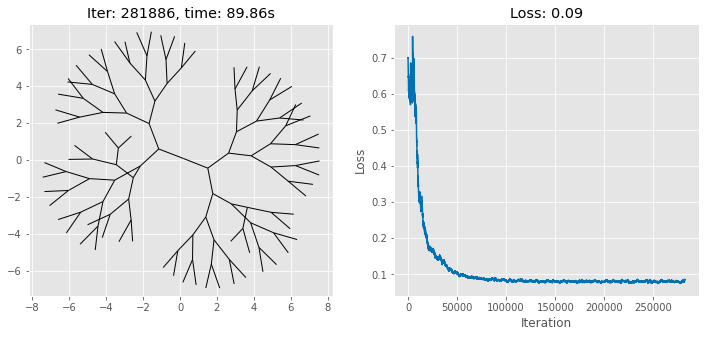

127


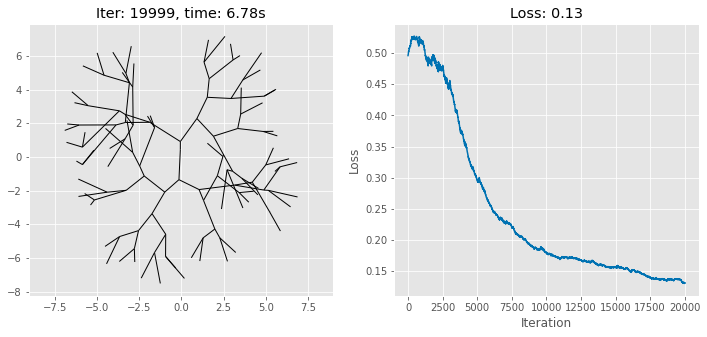

Epoch 34855: reducing learning rate of group 0 to 4.5000e-01.
Epoch 38944: reducing learning rate of group 0 to 4.0500e-01.


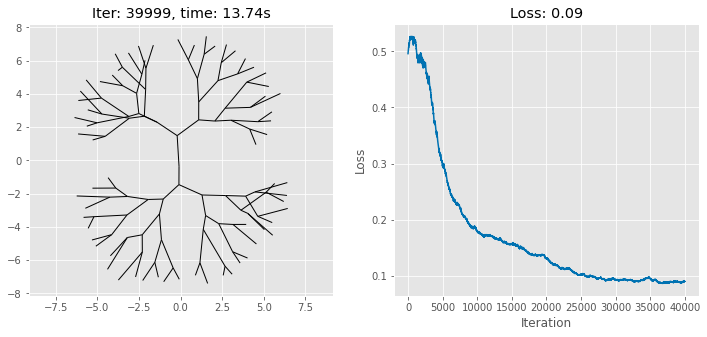

Epoch 43784: reducing learning rate of group 0 to 3.6450e-01.
Epoch 47651: reducing learning rate of group 0 to 3.2805e-01.
Epoch 50929: reducing learning rate of group 0 to 2.9525e-01.
Epoch 53030: reducing learning rate of group 0 to 2.6572e-01.
Epoch 55474: reducing learning rate of group 0 to 2.3915e-01.
Epoch 59518: reducing learning rate of group 0 to 2.1523e-01.


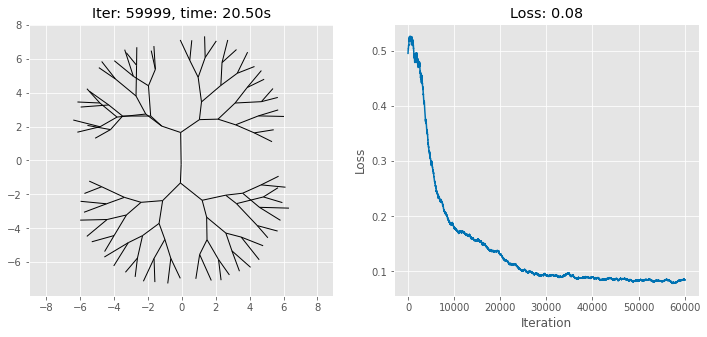

Epoch 61619: reducing learning rate of group 0 to 1.9371e-01.
Epoch 63720: reducing learning rate of group 0 to 1.7434e-01.
Epoch 65821: reducing learning rate of group 0 to 1.5691e-01.
Epoch 67922: reducing learning rate of group 0 to 1.4121e-01.
Epoch 70023: reducing learning rate of group 0 to 1.2709e-01.
Epoch 72124: reducing learning rate of group 0 to 1.1438e-01.
Epoch 75975: reducing learning rate of group 0 to 1.0295e-01.
Epoch 78076: reducing learning rate of group 0 to 9.2651e-02.


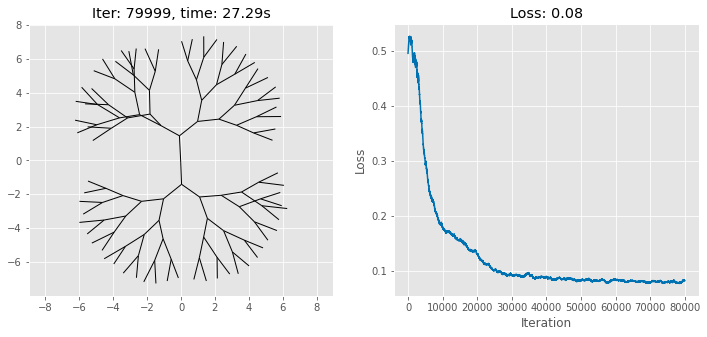

Epoch 80496: reducing learning rate of group 0 to 8.3386e-02.
Epoch 83123: reducing learning rate of group 0 to 7.5047e-02.
Epoch 85224: reducing learning rate of group 0 to 6.7543e-02.
Epoch 88473: reducing learning rate of group 0 to 6.0788e-02.
Epoch 90574: reducing learning rate of group 0 to 5.4709e-02.
Epoch 92675: reducing learning rate of group 0 to 4.9239e-02.
Epoch 94776: reducing learning rate of group 0 to 4.4315e-02.
Epoch 96877: reducing learning rate of group 0 to 3.9883e-02.
Epoch 98978: reducing learning rate of group 0 to 3.5895e-02.


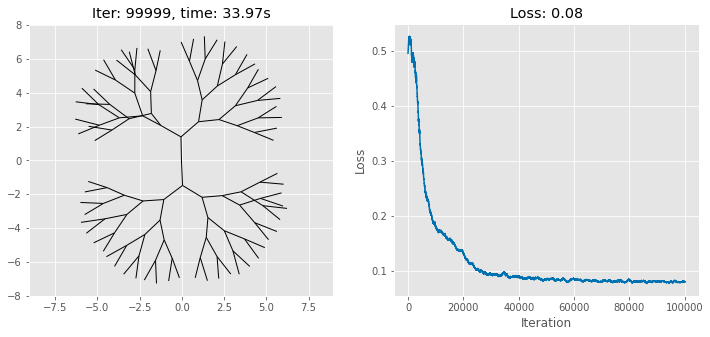

Epoch 101079: reducing learning rate of group 0 to 3.2305e-02.
Epoch 103180: reducing learning rate of group 0 to 2.9075e-02.
Epoch 105281: reducing learning rate of group 0 to 2.6167e-02.
Epoch 107382: reducing learning rate of group 0 to 2.3551e-02.
Epoch 109483: reducing learning rate of group 0 to 2.1196e-02.
Epoch 111584: reducing learning rate of group 0 to 1.9076e-02.
Epoch 115310: reducing learning rate of group 0 to 1.7168e-02.
Epoch 117411: reducing learning rate of group 0 to 1.5452e-02.
Epoch 119512: reducing learning rate of group 0 to 1.3906e-02.


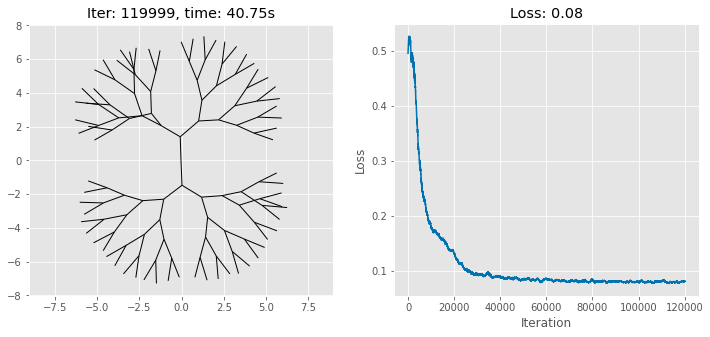

Epoch 121613: reducing learning rate of group 0 to 1.2516e-02.
Epoch 124180: reducing learning rate of group 0 to 1.1264e-02.
Epoch 126281: reducing learning rate of group 0 to 1.0138e-02.
Epoch 128382: reducing learning rate of group 0 to 9.1240e-03.
Epoch 130483: reducing learning rate of group 0 to 8.2116e-03.
Epoch 135300: reducing learning rate of group 0 to 7.3904e-03.
Epoch 137401: reducing learning rate of group 0 to 6.6514e-03.
Epoch 139502: reducing learning rate of group 0 to 5.9863e-03.


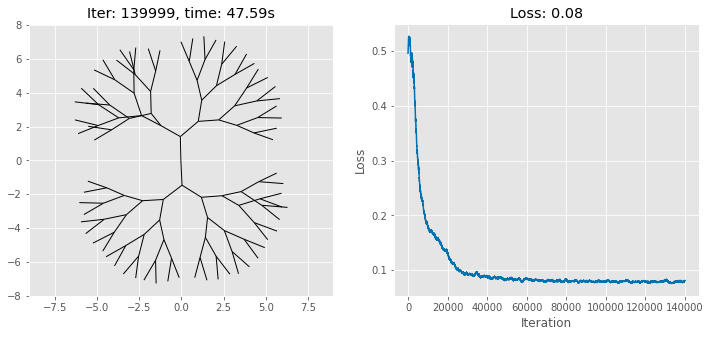

Epoch 141603: reducing learning rate of group 0 to 5.3876e-03.
Epoch 145532: reducing learning rate of group 0 to 4.8489e-03.
Epoch 147633: reducing learning rate of group 0 to 4.3640e-03.
Epoch 149734: reducing learning rate of group 0 to 3.9276e-03.
Epoch 151835: reducing learning rate of group 0 to 3.5348e-03.
Epoch 153936: reducing learning rate of group 0 to 3.1813e-03.
Epoch 156037: reducing learning rate of group 0 to 2.8632e-03.
Epoch 158138: reducing learning rate of group 0 to 2.5769e-03.


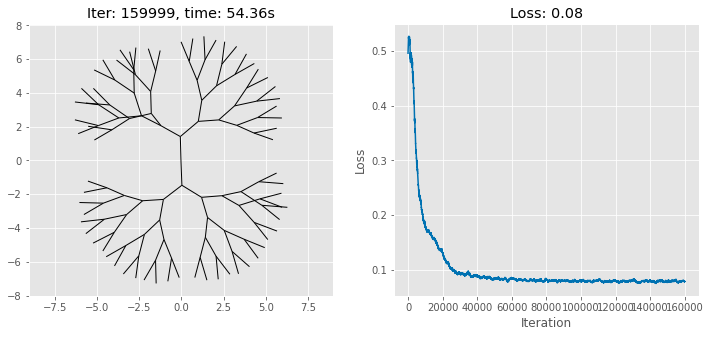

Epoch 160239: reducing learning rate of group 0 to 2.3192e-03.
Epoch 162340: reducing learning rate of group 0 to 2.0873e-03.
Epoch 164441: reducing learning rate of group 0 to 1.8786e-03.
Epoch 166542: reducing learning rate of group 0 to 1.6907e-03.
Epoch 168643: reducing learning rate of group 0 to 1.5216e-03.
Epoch 170744: reducing learning rate of group 0 to 1.3695e-03.
Epoch 172845: reducing learning rate of group 0 to 1.2325e-03.
Epoch 174946: reducing learning rate of group 0 to 1.1093e-03.
Epoch 177047: reducing learning rate of group 0 to 9.9834e-04.
Epoch 179148: reducing learning rate of group 0 to 8.9851e-04.


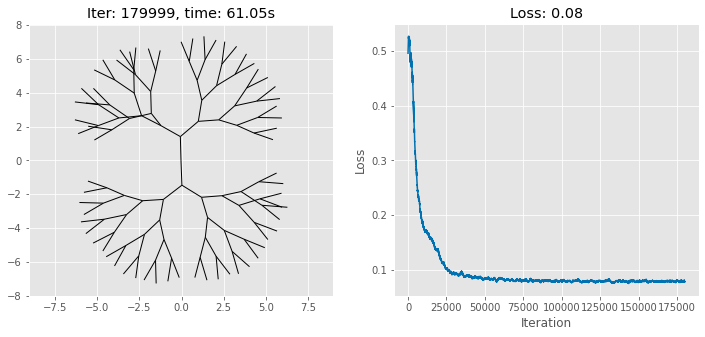

Epoch 181249: reducing learning rate of group 0 to 8.0865e-04.
Epoch 183350: reducing learning rate of group 0 to 7.2779e-04.
Epoch 185451: reducing learning rate of group 0 to 6.5501e-04.
Epoch 187552: reducing learning rate of group 0 to 5.8951e-04.
Epoch 189653: reducing learning rate of group 0 to 5.3056e-04.
Epoch 191754: reducing learning rate of group 0 to 4.7750e-04.
Epoch 193855: reducing learning rate of group 0 to 4.2975e-04.
Epoch 195956: reducing learning rate of group 0 to 3.8678e-04.
Epoch 198057: reducing learning rate of group 0 to 3.4810e-04.


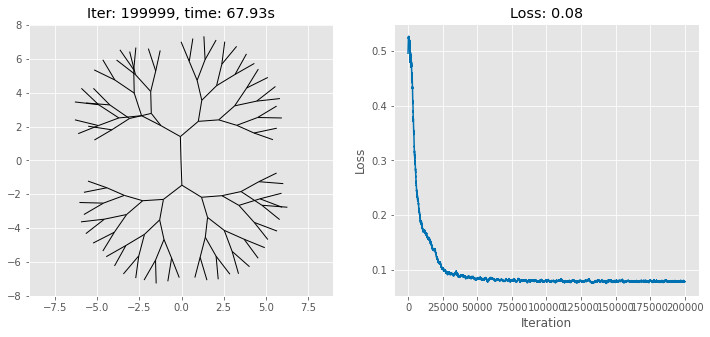

Epoch 200158: reducing learning rate of group 0 to 3.1329e-04.
Epoch 202259: reducing learning rate of group 0 to 2.8196e-04.
Epoch 204360: reducing learning rate of group 0 to 2.5376e-04.
Epoch 206461: reducing learning rate of group 0 to 2.2839e-04.
Epoch 208562: reducing learning rate of group 0 to 2.0555e-04.
Epoch 210663: reducing learning rate of group 0 to 1.8499e-04.
Epoch 212764: reducing learning rate of group 0 to 1.6649e-04.
Epoch 214865: reducing learning rate of group 0 to 1.4985e-04.
Epoch 216966: reducing learning rate of group 0 to 1.3486e-04.
Epoch 219067: reducing learning rate of group 0 to 1.2137e-04.


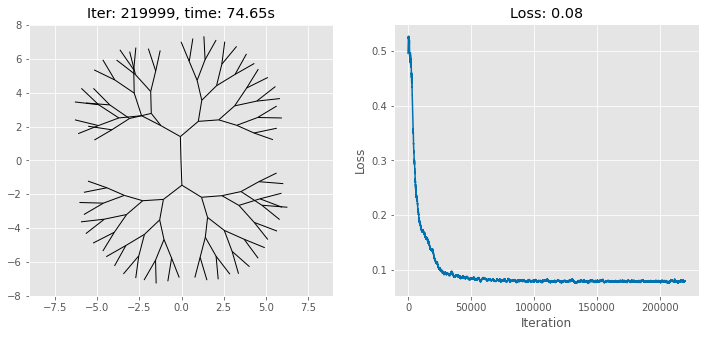

Epoch 221168: reducing learning rate of group 0 to 1.0924e-04.
Epoch 223269: reducing learning rate of group 0 to 9.8314e-05.
Epoch 225370: reducing learning rate of group 0 to 8.8482e-05.
Epoch 227471: reducing learning rate of group 0 to 7.9634e-05.
Epoch 229572: reducing learning rate of group 0 to 7.1671e-05.
Epoch 231673: reducing learning rate of group 0 to 6.4504e-05.
Epoch 233774: reducing learning rate of group 0 to 5.8053e-05.
Epoch 235875: reducing learning rate of group 0 to 5.2248e-05.
Epoch 237976: reducing learning rate of group 0 to 4.7023e-05.


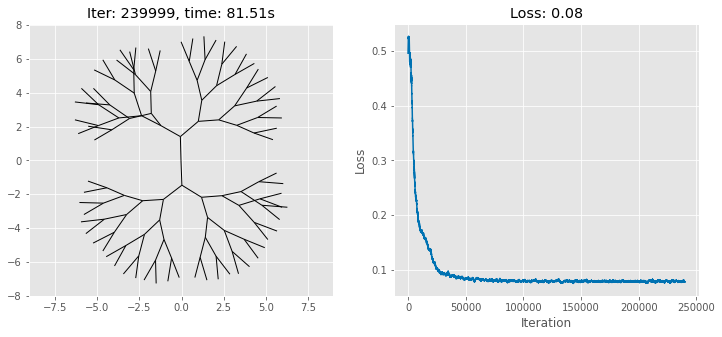

Epoch 240077: reducing learning rate of group 0 to 4.2321e-05.
Epoch 242178: reducing learning rate of group 0 to 3.8089e-05.
Epoch 244279: reducing learning rate of group 0 to 3.4280e-05.
Epoch 246380: reducing learning rate of group 0 to 3.0852e-05.
Epoch 248481: reducing learning rate of group 0 to 2.7767e-05.
Epoch 250582: reducing learning rate of group 0 to 2.4990e-05.
Epoch 252683: reducing learning rate of group 0 to 2.2491e-05.
Epoch 254784: reducing learning rate of group 0 to 2.0242e-05.
Epoch 256885: reducing learning rate of group 0 to 1.8218e-05.
Epoch 258986: reducing learning rate of group 0 to 1.6396e-05.


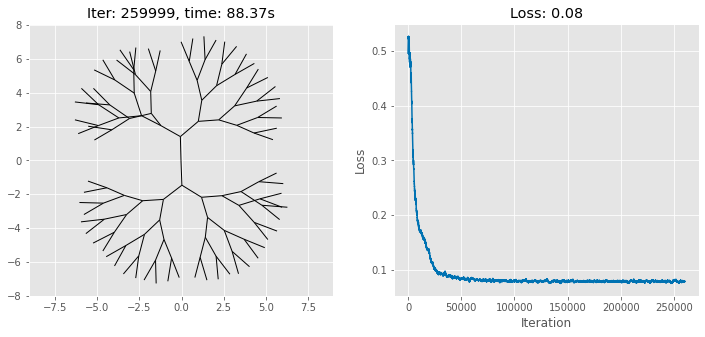

Epoch 261087: reducing learning rate of group 0 to 1.4756e-05.
Epoch 263188: reducing learning rate of group 0 to 1.3281e-05.
Epoch 265289: reducing learning rate of group 0 to 1.1953e-05.
Epoch 267390: reducing learning rate of group 0 to 1.0757e-05.
Epoch 269491: reducing learning rate of group 0 to 1.0000e-05.



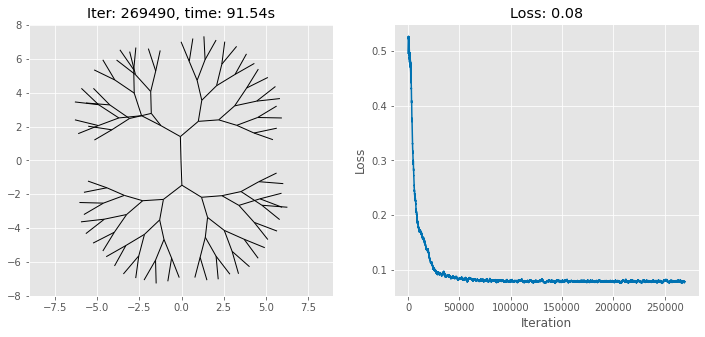

127


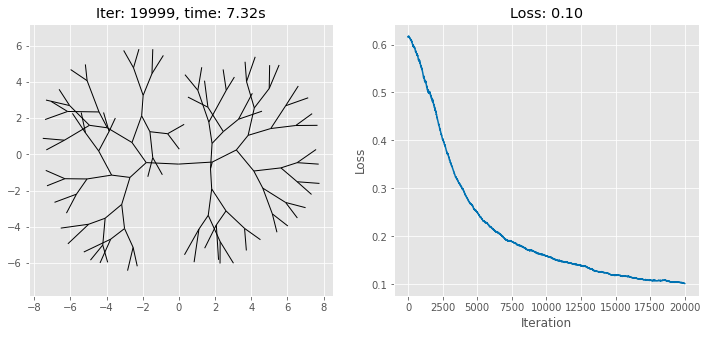

Epoch 39171: reducing learning rate of group 0 to 4.5000e-01.


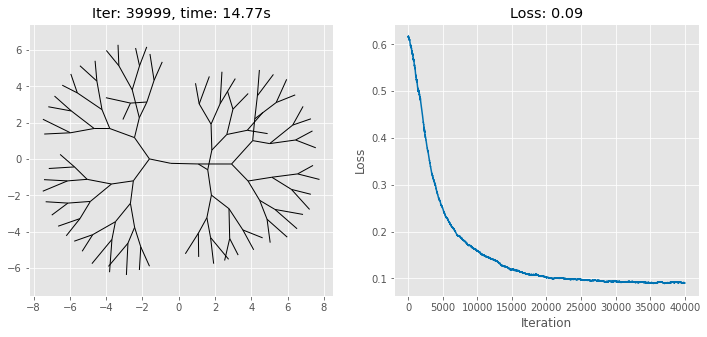

Epoch 43375: reducing learning rate of group 0 to 4.0500e-01.
Epoch 49095: reducing learning rate of group 0 to 3.6450e-01.
Epoch 51196: reducing learning rate of group 0 to 3.2805e-01.
Epoch 53297: reducing learning rate of group 0 to 2.9525e-01.
Epoch 55398: reducing learning rate of group 0 to 2.6572e-01.


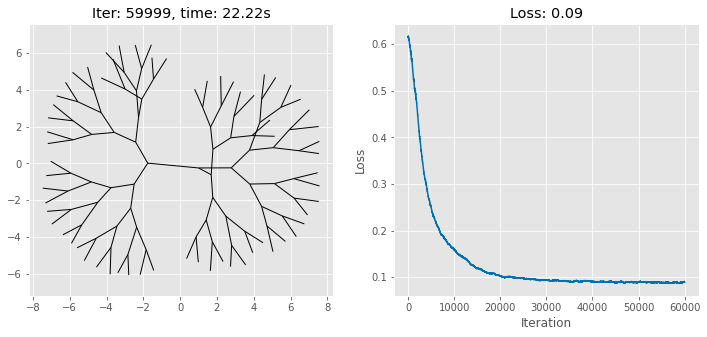

Epoch 60957: reducing learning rate of group 0 to 2.3915e-01.
Epoch 63058: reducing learning rate of group 0 to 2.1523e-01.
Epoch 65159: reducing learning rate of group 0 to 1.9371e-01.
Epoch 67771: reducing learning rate of group 0 to 1.7434e-01.
Epoch 73924: reducing learning rate of group 0 to 1.5691e-01.
Epoch 76025: reducing learning rate of group 0 to 1.4121e-01.
Epoch 78126: reducing learning rate of group 0 to 1.2709e-01.


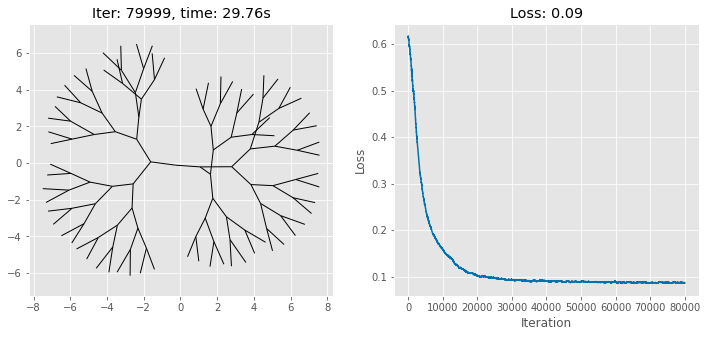

Epoch 80227: reducing learning rate of group 0 to 1.1438e-01.
Epoch 82328: reducing learning rate of group 0 to 1.0295e-01.
Epoch 84429: reducing learning rate of group 0 to 9.2651e-02.
Epoch 87199: reducing learning rate of group 0 to 8.3386e-02.
Epoch 89300: reducing learning rate of group 0 to 7.5047e-02.
Epoch 91401: reducing learning rate of group 0 to 6.7543e-02.
Epoch 93502: reducing learning rate of group 0 to 6.0788e-02.
Epoch 97605: reducing learning rate of group 0 to 5.4709e-02.
Epoch 99706: reducing learning rate of group 0 to 4.9239e-02.


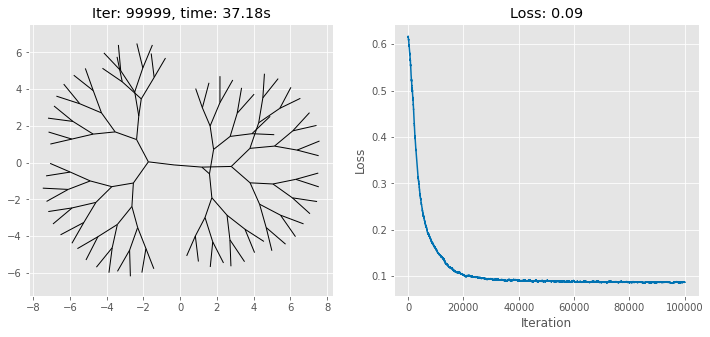

Epoch 101807: reducing learning rate of group 0 to 4.4315e-02.
Epoch 103908: reducing learning rate of group 0 to 3.9883e-02.
Epoch 106009: reducing learning rate of group 0 to 3.5895e-02.
Epoch 108110: reducing learning rate of group 0 to 3.2305e-02.
Epoch 110211: reducing learning rate of group 0 to 2.9075e-02.
Epoch 112312: reducing learning rate of group 0 to 2.6167e-02.
Epoch 114413: reducing learning rate of group 0 to 2.3551e-02.
Epoch 116514: reducing learning rate of group 0 to 2.1196e-02.
Epoch 118615: reducing learning rate of group 0 to 1.9076e-02.


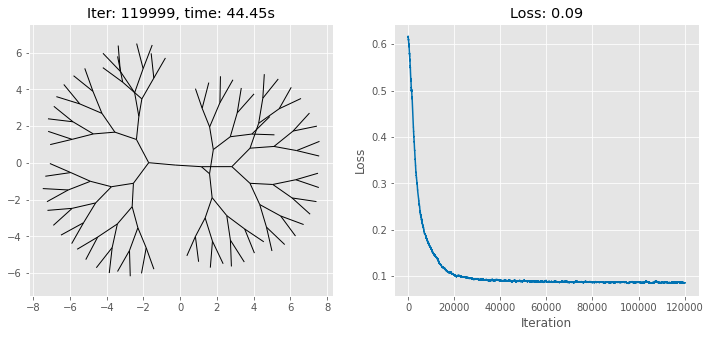

Epoch 120716: reducing learning rate of group 0 to 1.7168e-02.
Epoch 122817: reducing learning rate of group 0 to 1.5452e-02.
Epoch 124918: reducing learning rate of group 0 to 1.3906e-02.
Epoch 127019: reducing learning rate of group 0 to 1.2516e-02.
Epoch 130511: reducing learning rate of group 0 to 1.1264e-02.
Epoch 132612: reducing learning rate of group 0 to 1.0138e-02.
Epoch 134713: reducing learning rate of group 0 to 9.1240e-03.
Epoch 136814: reducing learning rate of group 0 to 8.2116e-03.
Epoch 139945: reducing learning rate of group 0 to 7.3904e-03.


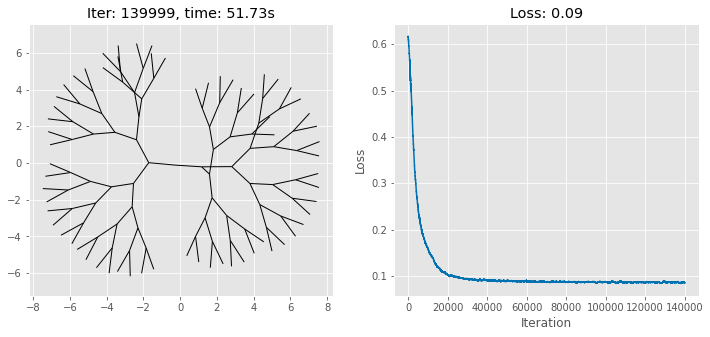

Epoch 142330: reducing learning rate of group 0 to 6.6514e-03.
Epoch 144431: reducing learning rate of group 0 to 5.9863e-03.
Epoch 146532: reducing learning rate of group 0 to 5.3876e-03.
Epoch 148633: reducing learning rate of group 0 to 4.8489e-03.
Epoch 150734: reducing learning rate of group 0 to 4.3640e-03.
Epoch 152835: reducing learning rate of group 0 to 3.9276e-03.
Epoch 154936: reducing learning rate of group 0 to 3.5348e-03.
Epoch 157037: reducing learning rate of group 0 to 3.1813e-03.
Epoch 159138: reducing learning rate of group 0 to 2.8632e-03.


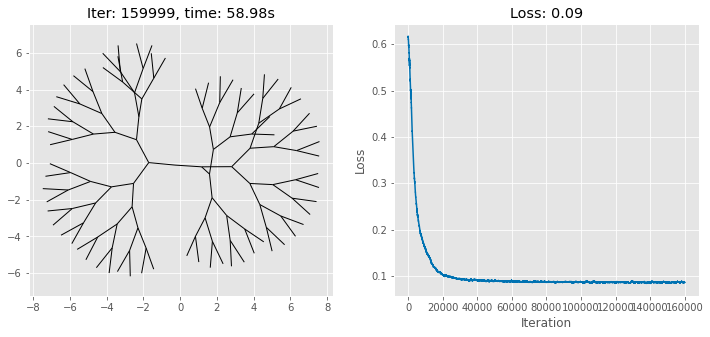

Epoch 161239: reducing learning rate of group 0 to 2.5769e-03.
Epoch 163340: reducing learning rate of group 0 to 2.3192e-03.
Epoch 165441: reducing learning rate of group 0 to 2.0873e-03.
Epoch 167542: reducing learning rate of group 0 to 1.8786e-03.
Epoch 169643: reducing learning rate of group 0 to 1.6907e-03.
Epoch 171744: reducing learning rate of group 0 to 1.5216e-03.
Epoch 173845: reducing learning rate of group 0 to 1.3695e-03.
Epoch 175946: reducing learning rate of group 0 to 1.2325e-03.
Epoch 178047: reducing learning rate of group 0 to 1.1093e-03.


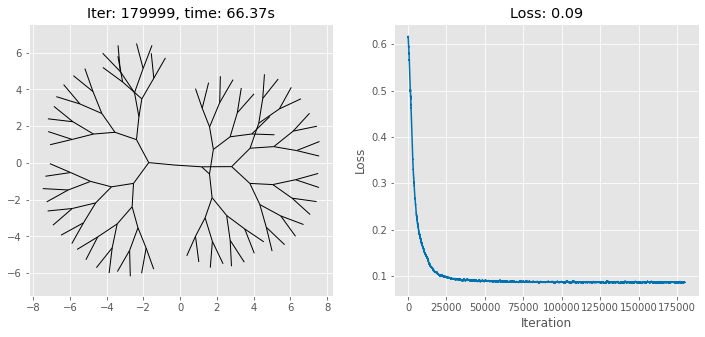

Epoch 180148: reducing learning rate of group 0 to 9.9834e-04.
Epoch 182249: reducing learning rate of group 0 to 8.9851e-04.
Epoch 184350: reducing learning rate of group 0 to 8.0865e-04.
Epoch 186451: reducing learning rate of group 0 to 7.2779e-04.
Epoch 188552: reducing learning rate of group 0 to 6.5501e-04.
Epoch 190653: reducing learning rate of group 0 to 5.8951e-04.
Epoch 192754: reducing learning rate of group 0 to 5.3056e-04.
Epoch 194855: reducing learning rate of group 0 to 4.7750e-04.
Epoch 196956: reducing learning rate of group 0 to 4.2975e-04.
Epoch 199057: reducing learning rate of group 0 to 3.8678e-04.


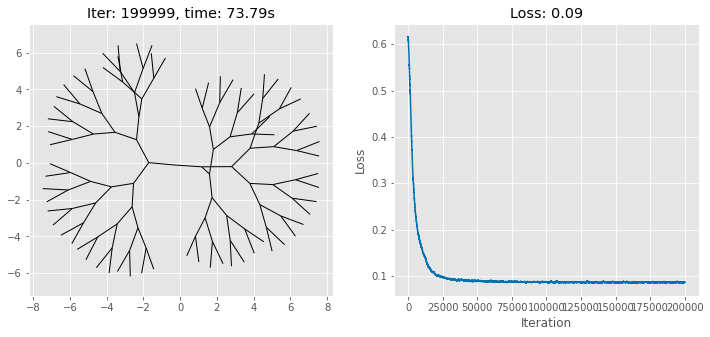

Epoch 201158: reducing learning rate of group 0 to 3.4810e-04.
Epoch 203259: reducing learning rate of group 0 to 3.1329e-04.
Epoch 205360: reducing learning rate of group 0 to 2.8196e-04.
Epoch 207461: reducing learning rate of group 0 to 2.5376e-04.
Epoch 209562: reducing learning rate of group 0 to 2.2839e-04.
Epoch 211663: reducing learning rate of group 0 to 2.0555e-04.
Epoch 213764: reducing learning rate of group 0 to 1.8499e-04.
Epoch 215865: reducing learning rate of group 0 to 1.6649e-04.
Epoch 217966: reducing learning rate of group 0 to 1.4985e-04.


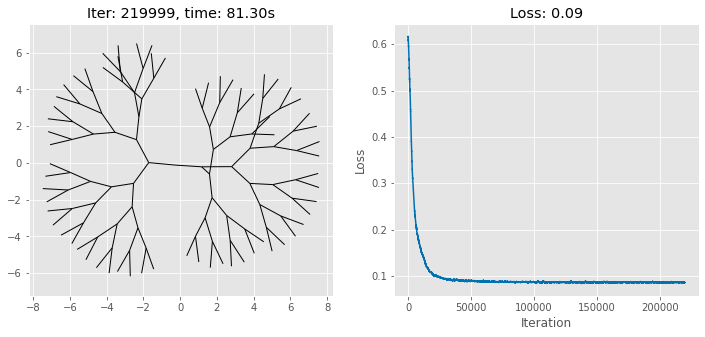

Epoch 220067: reducing learning rate of group 0 to 1.3486e-04.
Epoch 222168: reducing learning rate of group 0 to 1.2137e-04.
Epoch 224269: reducing learning rate of group 0 to 1.0924e-04.
Epoch 226370: reducing learning rate of group 0 to 9.8314e-05.
Epoch 228471: reducing learning rate of group 0 to 8.8482e-05.
Epoch 230572: reducing learning rate of group 0 to 7.9634e-05.
Epoch 232673: reducing learning rate of group 0 to 7.1671e-05.
Epoch 234774: reducing learning rate of group 0 to 6.4504e-05.
Epoch 236875: reducing learning rate of group 0 to 5.8053e-05.
Epoch 238976: reducing learning rate of group 0 to 5.2248e-05.


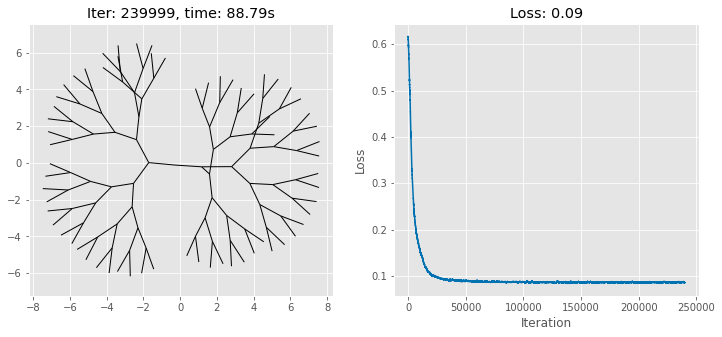

Epoch 241077: reducing learning rate of group 0 to 4.7023e-05.
Epoch 243178: reducing learning rate of group 0 to 4.2321e-05.
Epoch 245279: reducing learning rate of group 0 to 3.8089e-05.
Epoch 247380: reducing learning rate of group 0 to 3.4280e-05.
Epoch 249481: reducing learning rate of group 0 to 3.0852e-05.
Epoch 251582: reducing learning rate of group 0 to 2.7767e-05.
Epoch 253683: reducing learning rate of group 0 to 2.4990e-05.
Epoch 255784: reducing learning rate of group 0 to 2.2491e-05.
Epoch 257885: reducing learning rate of group 0 to 2.0242e-05.
Epoch 259986: reducing learning rate of group 0 to 1.8218e-05.


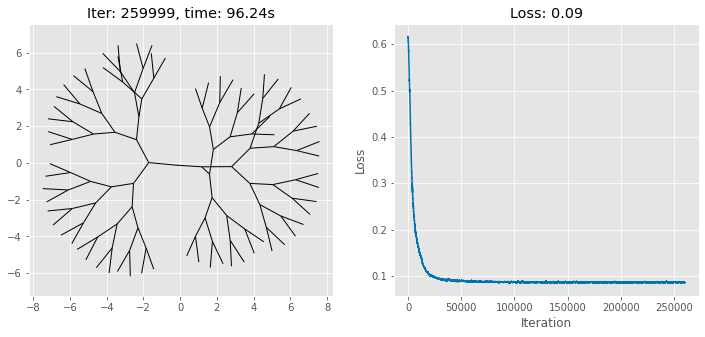

Epoch 262087: reducing learning rate of group 0 to 1.6396e-05.
Epoch 264188: reducing learning rate of group 0 to 1.4756e-05.
Epoch 266289: reducing learning rate of group 0 to 1.3281e-05.
Epoch 268390: reducing learning rate of group 0 to 1.1953e-05.
Epoch 270491: reducing learning rate of group 0 to 1.0757e-05.
Epoch 272592: reducing learning rate of group 0 to 1.0000e-05.



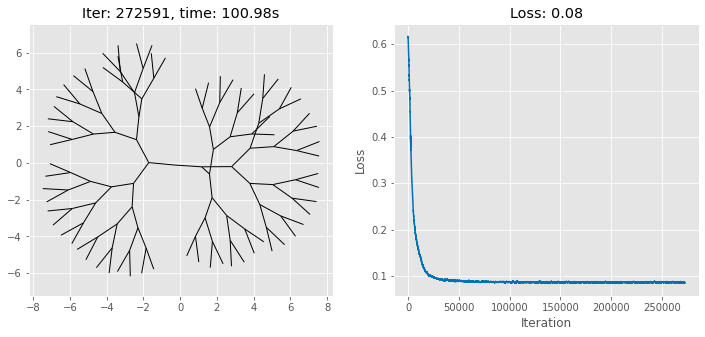

127


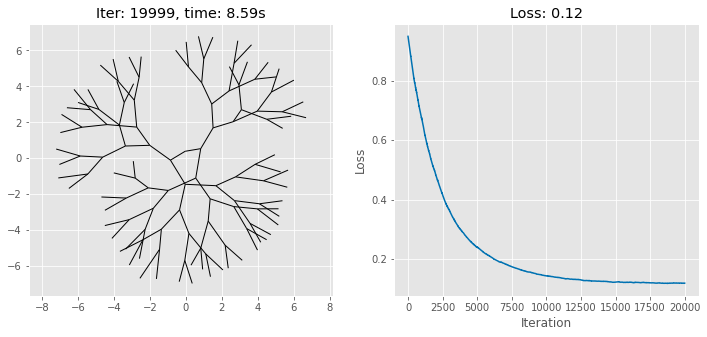

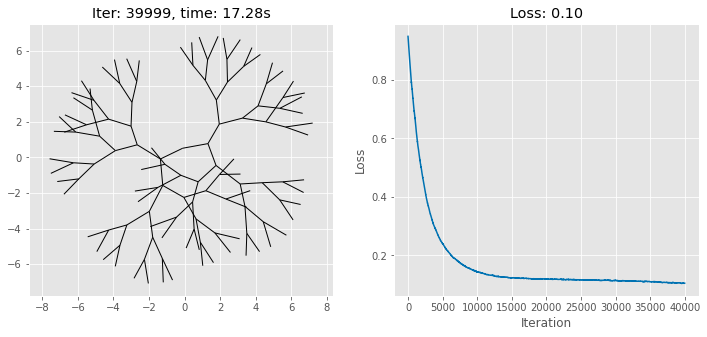

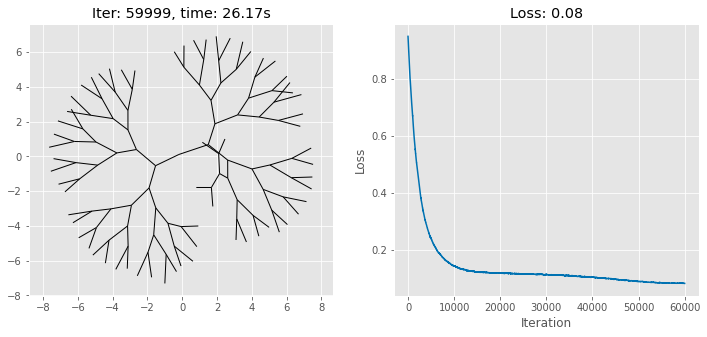

Epoch 69285: reducing learning rate of group 0 to 4.5000e-01.
Epoch 74194: reducing learning rate of group 0 to 4.0500e-01.
Epoch 77241: reducing learning rate of group 0 to 3.6450e-01.


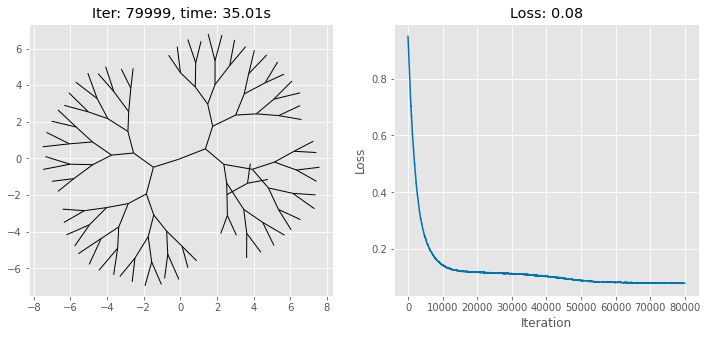

Epoch 81143: reducing learning rate of group 0 to 3.2805e-01.
Epoch 83565: reducing learning rate of group 0 to 2.9525e-01.
Epoch 91258: reducing learning rate of group 0 to 2.6572e-01.
Epoch 94560: reducing learning rate of group 0 to 2.3915e-01.
Epoch 96661: reducing learning rate of group 0 to 2.1523e-01.


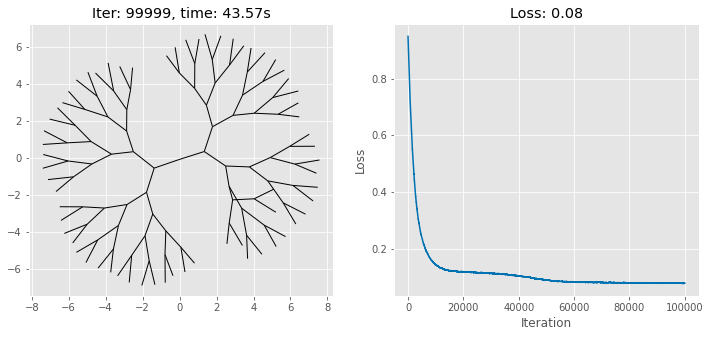

Epoch 101427: reducing learning rate of group 0 to 1.9371e-01.
Epoch 103528: reducing learning rate of group 0 to 1.7434e-01.
Epoch 105629: reducing learning rate of group 0 to 1.5691e-01.
Epoch 109547: reducing learning rate of group 0 to 1.4121e-01.
Epoch 111648: reducing learning rate of group 0 to 1.2709e-01.
Epoch 115303: reducing learning rate of group 0 to 1.1438e-01.
Epoch 117404: reducing learning rate of group 0 to 1.0295e-01.
Epoch 119505: reducing learning rate of group 0 to 9.2651e-02.


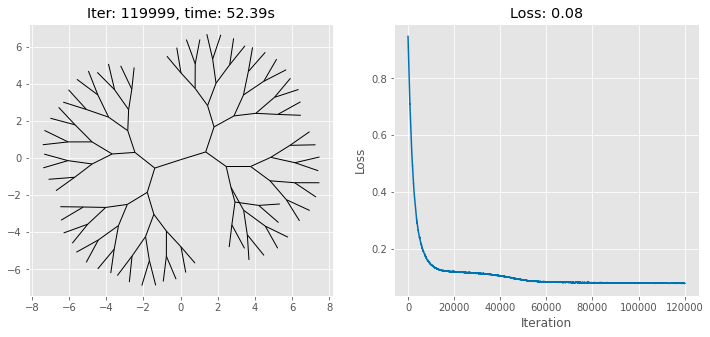

Epoch 121606: reducing learning rate of group 0 to 8.3386e-02.
Epoch 125503: reducing learning rate of group 0 to 7.5047e-02.
Epoch 127604: reducing learning rate of group 0 to 6.7543e-02.
Epoch 129705: reducing learning rate of group 0 to 6.0788e-02.
Epoch 131806: reducing learning rate of group 0 to 5.4709e-02.
Epoch 133907: reducing learning rate of group 0 to 4.9239e-02.
Epoch 136008: reducing learning rate of group 0 to 4.4315e-02.
Epoch 138109: reducing learning rate of group 0 to 3.9883e-02.


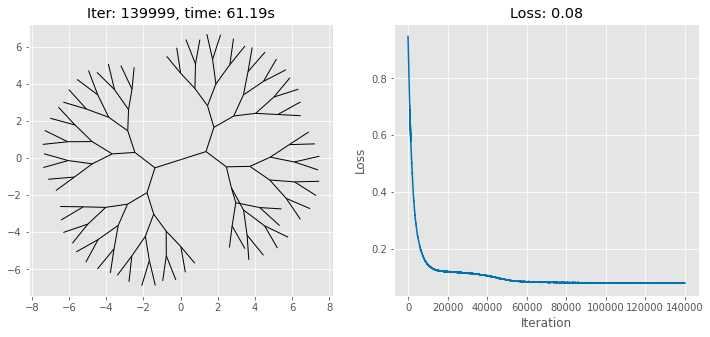

Epoch 140210: reducing learning rate of group 0 to 3.5895e-02.
Epoch 142861: reducing learning rate of group 0 to 3.2305e-02.
Epoch 144962: reducing learning rate of group 0 to 2.9075e-02.
Epoch 147063: reducing learning rate of group 0 to 2.6167e-02.
Epoch 149164: reducing learning rate of group 0 to 2.3551e-02.
Epoch 151265: reducing learning rate of group 0 to 2.1196e-02.
Epoch 153366: reducing learning rate of group 0 to 1.9076e-02.
Epoch 155467: reducing learning rate of group 0 to 1.7168e-02.
Epoch 157568: reducing learning rate of group 0 to 1.5452e-02.
Epoch 159669: reducing learning rate of group 0 to 1.3906e-02.


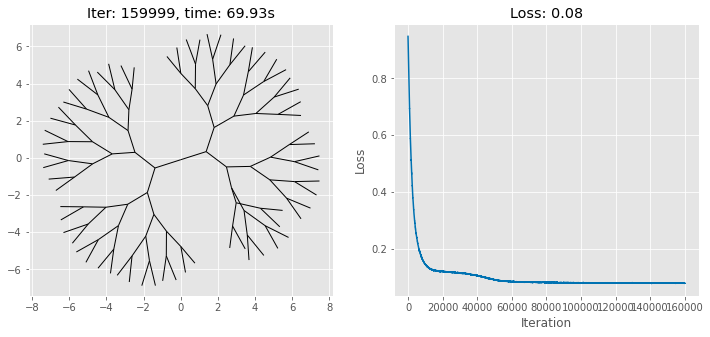

Epoch 161770: reducing learning rate of group 0 to 1.2516e-02.
Epoch 163871: reducing learning rate of group 0 to 1.1264e-02.
Epoch 165972: reducing learning rate of group 0 to 1.0138e-02.
Epoch 168073: reducing learning rate of group 0 to 9.1240e-03.
Epoch 170174: reducing learning rate of group 0 to 8.2116e-03.
Epoch 172275: reducing learning rate of group 0 to 7.3904e-03.
Epoch 174376: reducing learning rate of group 0 to 6.6514e-03.
Epoch 176477: reducing learning rate of group 0 to 5.9863e-03.
Epoch 178578: reducing learning rate of group 0 to 5.3876e-03.


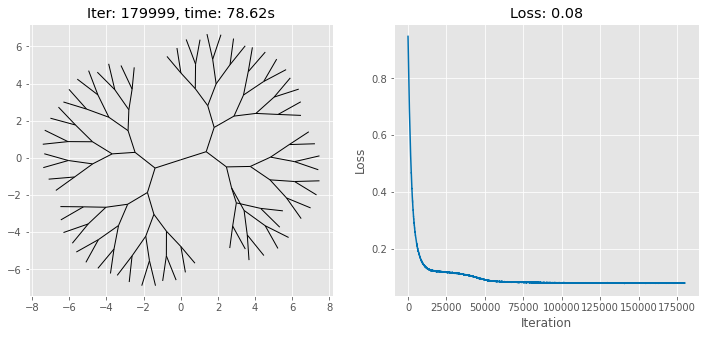

Epoch 180679: reducing learning rate of group 0 to 4.8489e-03.
Epoch 182780: reducing learning rate of group 0 to 4.3640e-03.
Epoch 184881: reducing learning rate of group 0 to 3.9276e-03.
Epoch 186982: reducing learning rate of group 0 to 3.5348e-03.
Epoch 189083: reducing learning rate of group 0 to 3.1813e-03.
Epoch 191184: reducing learning rate of group 0 to 2.8632e-03.
Epoch 193285: reducing learning rate of group 0 to 2.5769e-03.
Epoch 195386: reducing learning rate of group 0 to 2.3192e-03.
Epoch 197487: reducing learning rate of group 0 to 2.0873e-03.
Epoch 199588: reducing learning rate of group 0 to 1.8786e-03.


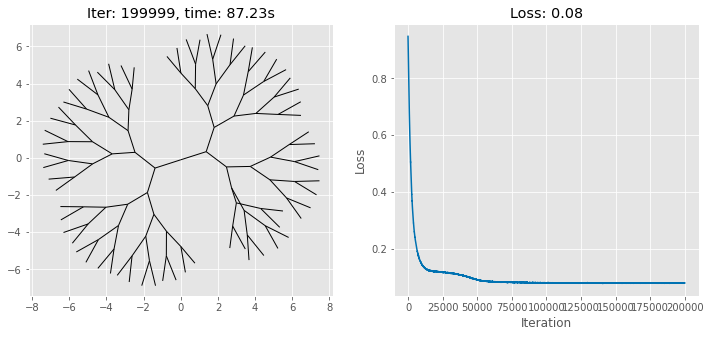

Epoch 201689: reducing learning rate of group 0 to 1.6907e-03.
Epoch 203790: reducing learning rate of group 0 to 1.5216e-03.
Epoch 205891: reducing learning rate of group 0 to 1.3695e-03.
Epoch 207992: reducing learning rate of group 0 to 1.2325e-03.
Epoch 210093: reducing learning rate of group 0 to 1.1093e-03.
Epoch 212194: reducing learning rate of group 0 to 9.9834e-04.
Epoch 214295: reducing learning rate of group 0 to 8.9851e-04.
Epoch 216396: reducing learning rate of group 0 to 8.0865e-04.
Epoch 218497: reducing learning rate of group 0 to 7.2779e-04.


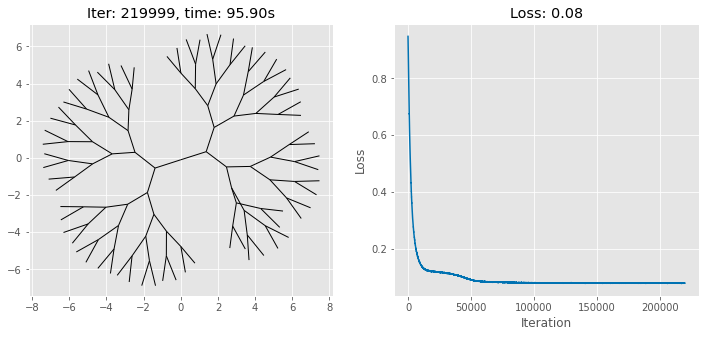

Epoch 222608: reducing learning rate of group 0 to 6.5501e-04.
Epoch 224709: reducing learning rate of group 0 to 5.8951e-04.
Epoch 226810: reducing learning rate of group 0 to 5.3056e-04.
Epoch 228911: reducing learning rate of group 0 to 4.7750e-04.
Epoch 231012: reducing learning rate of group 0 to 4.2975e-04.
Epoch 233113: reducing learning rate of group 0 to 3.8678e-04.
Epoch 235214: reducing learning rate of group 0 to 3.4810e-04.
Epoch 237315: reducing learning rate of group 0 to 3.1329e-04.
Epoch 239416: reducing learning rate of group 0 to 2.8196e-04.


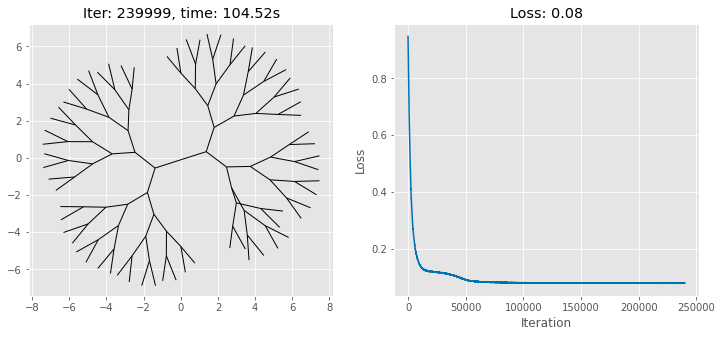

Epoch 241517: reducing learning rate of group 0 to 2.5376e-04.
Epoch 243618: reducing learning rate of group 0 to 2.2839e-04.
Epoch 245719: reducing learning rate of group 0 to 2.0555e-04.
Epoch 247820: reducing learning rate of group 0 to 1.8499e-04.
Epoch 249921: reducing learning rate of group 0 to 1.6649e-04.
Epoch 252022: reducing learning rate of group 0 to 1.4985e-04.
Epoch 254123: reducing learning rate of group 0 to 1.3486e-04.
Epoch 256224: reducing learning rate of group 0 to 1.2137e-04.
Epoch 258325: reducing learning rate of group 0 to 1.0924e-04.


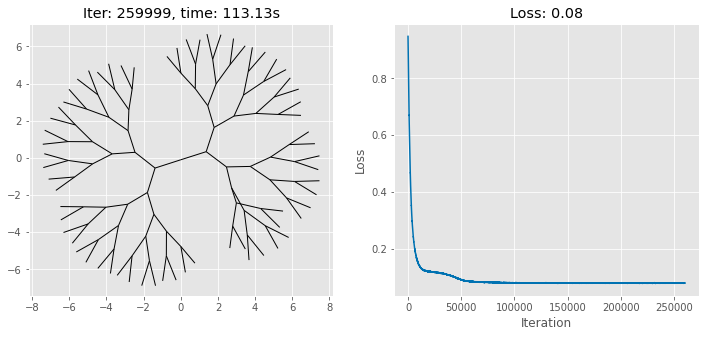

Epoch 260426: reducing learning rate of group 0 to 9.8314e-05.
Epoch 262527: reducing learning rate of group 0 to 8.8482e-05.
Epoch 264628: reducing learning rate of group 0 to 7.9634e-05.
Epoch 266729: reducing learning rate of group 0 to 7.1671e-05.
Epoch 268830: reducing learning rate of group 0 to 6.4504e-05.
Epoch 270931: reducing learning rate of group 0 to 5.8053e-05.
Epoch 273032: reducing learning rate of group 0 to 5.2248e-05.
Epoch 275133: reducing learning rate of group 0 to 4.7023e-05.
Epoch 277234: reducing learning rate of group 0 to 4.2321e-05.
Epoch 279832: reducing learning rate of group 0 to 3.8089e-05.


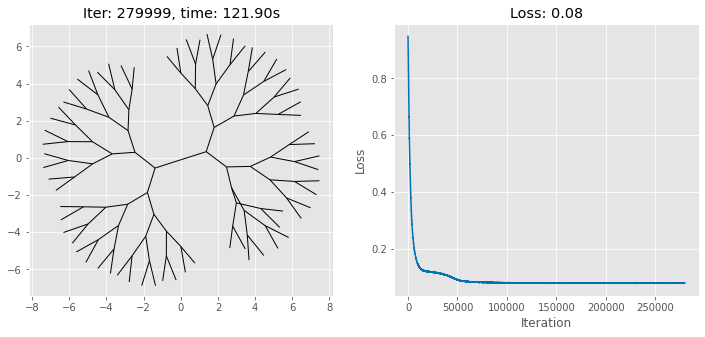

Epoch 281933: reducing learning rate of group 0 to 3.4280e-05.
Epoch 284034: reducing learning rate of group 0 to 3.0852e-05.
Epoch 286135: reducing learning rate of group 0 to 2.7767e-05.
Epoch 288236: reducing learning rate of group 0 to 2.4990e-05.
Epoch 290337: reducing learning rate of group 0 to 2.2491e-05.
Epoch 292438: reducing learning rate of group 0 to 2.0242e-05.
Epoch 294539: reducing learning rate of group 0 to 1.8218e-05.
Epoch 296640: reducing learning rate of group 0 to 1.6396e-05.
Epoch 298741: reducing learning rate of group 0 to 1.4756e-05.


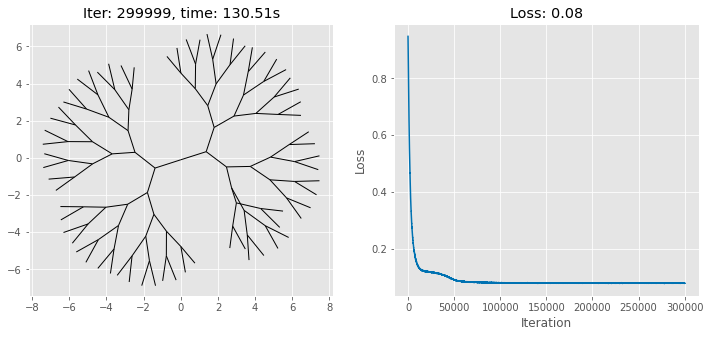

Epoch 300842: reducing learning rate of group 0 to 1.3281e-05.
Epoch 302943: reducing learning rate of group 0 to 1.1953e-05.
Epoch 305044: reducing learning rate of group 0 to 1.0757e-05.
Epoch 307145: reducing learning rate of group 0 to 1.0000e-05.



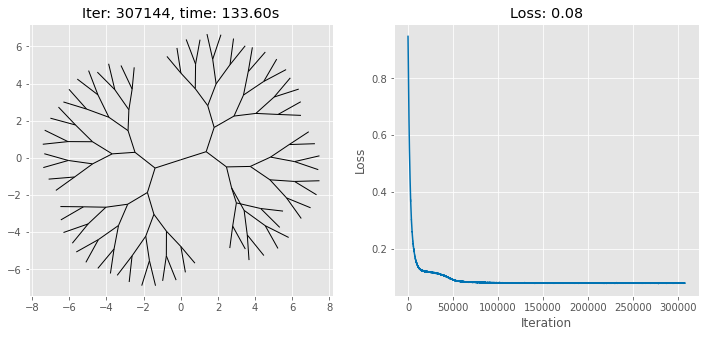

127


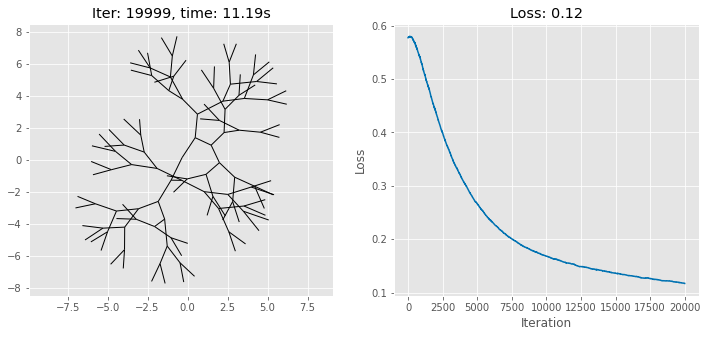

Epoch 38200: reducing learning rate of group 0 to 4.5000e-01.


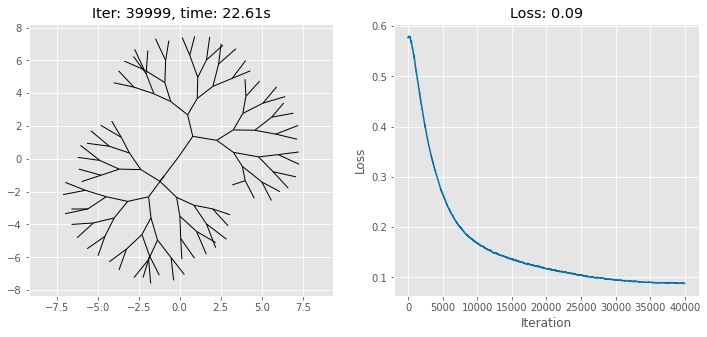

Epoch 49008: reducing learning rate of group 0 to 4.0500e-01.
Epoch 52749: reducing learning rate of group 0 to 3.6450e-01.
Epoch 56710: reducing learning rate of group 0 to 3.2805e-01.


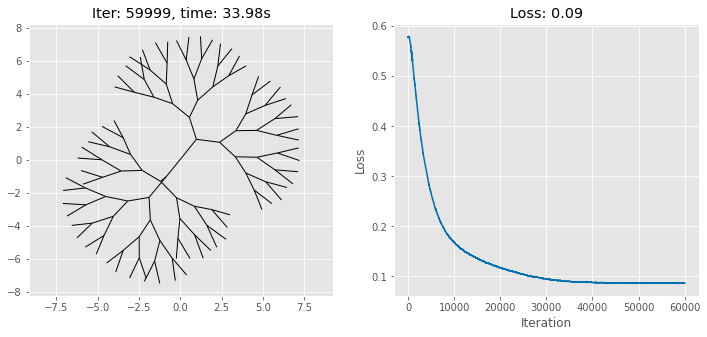

Epoch 60821: reducing learning rate of group 0 to 2.9525e-01.
Epoch 64318: reducing learning rate of group 0 to 2.6572e-01.
Epoch 66419: reducing learning rate of group 0 to 2.3915e-01.
Epoch 69466: reducing learning rate of group 0 to 2.1523e-01.
Epoch 71567: reducing learning rate of group 0 to 1.9371e-01.
Epoch 74613: reducing learning rate of group 0 to 1.7434e-01.
Epoch 78723: reducing learning rate of group 0 to 1.5691e-01.


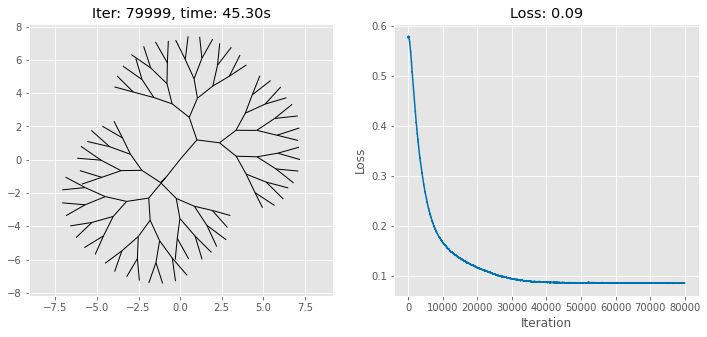

Epoch 80824: reducing learning rate of group 0 to 1.4121e-01.
Epoch 84118: reducing learning rate of group 0 to 1.2709e-01.
Epoch 86219: reducing learning rate of group 0 to 1.1438e-01.
Epoch 88320: reducing learning rate of group 0 to 1.0295e-01.
Epoch 90421: reducing learning rate of group 0 to 9.2651e-02.
Epoch 92522: reducing learning rate of group 0 to 8.3386e-02.
Epoch 94623: reducing learning rate of group 0 to 7.5047e-02.
Epoch 96724: reducing learning rate of group 0 to 6.7543e-02.
Epoch 98825: reducing learning rate of group 0 to 6.0788e-02.


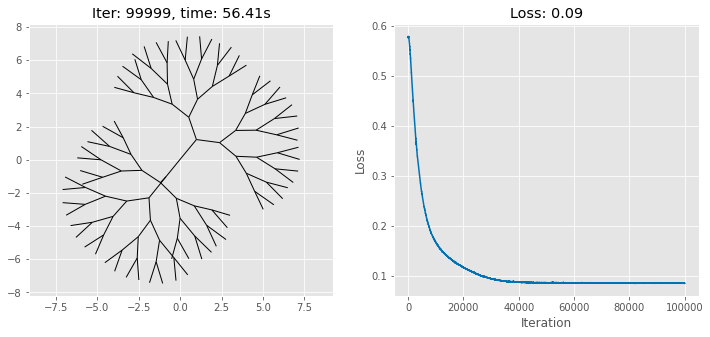

Epoch 100926: reducing learning rate of group 0 to 5.4709e-02.
Epoch 103220: reducing learning rate of group 0 to 4.9239e-02.
Epoch 105321: reducing learning rate of group 0 to 4.4315e-02.
Epoch 107422: reducing learning rate of group 0 to 3.9883e-02.
Epoch 109523: reducing learning rate of group 0 to 3.5895e-02.
Epoch 111624: reducing learning rate of group 0 to 3.2305e-02.
Epoch 113822: reducing learning rate of group 0 to 2.9075e-02.
Epoch 117976: reducing learning rate of group 0 to 2.6167e-02.


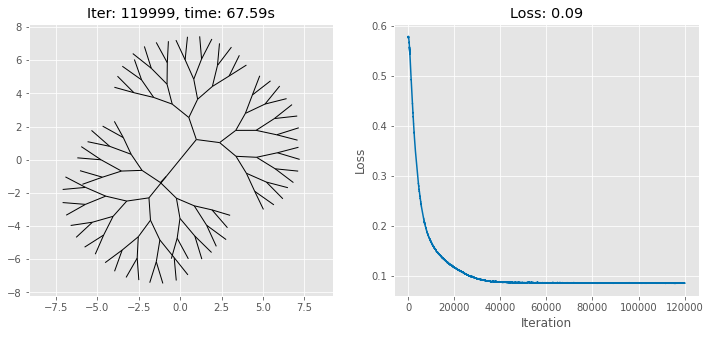

Epoch 120077: reducing learning rate of group 0 to 2.3551e-02.
Epoch 122178: reducing learning rate of group 0 to 2.1196e-02.
Epoch 124279: reducing learning rate of group 0 to 1.9076e-02.
Epoch 126380: reducing learning rate of group 0 to 1.7168e-02.
Epoch 128481: reducing learning rate of group 0 to 1.5452e-02.
Epoch 130582: reducing learning rate of group 0 to 1.3906e-02.
Epoch 133010: reducing learning rate of group 0 to 1.2516e-02.
Epoch 135111: reducing learning rate of group 0 to 1.1264e-02.
Epoch 137212: reducing learning rate of group 0 to 1.0138e-02.
Epoch 139313: reducing learning rate of group 0 to 9.1240e-03.


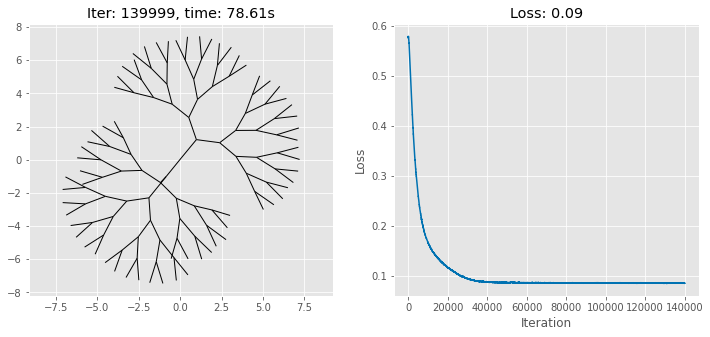

Epoch 141414: reducing learning rate of group 0 to 8.2116e-03.
Epoch 144108: reducing learning rate of group 0 to 7.3904e-03.
Epoch 146209: reducing learning rate of group 0 to 6.6514e-03.
Epoch 148310: reducing learning rate of group 0 to 5.9863e-03.
Epoch 150411: reducing learning rate of group 0 to 5.3876e-03.
Epoch 152512: reducing learning rate of group 0 to 4.8489e-03.
Epoch 154613: reducing learning rate of group 0 to 4.3640e-03.
Epoch 156714: reducing learning rate of group 0 to 3.9276e-03.
Epoch 158815: reducing learning rate of group 0 to 3.5348e-03.


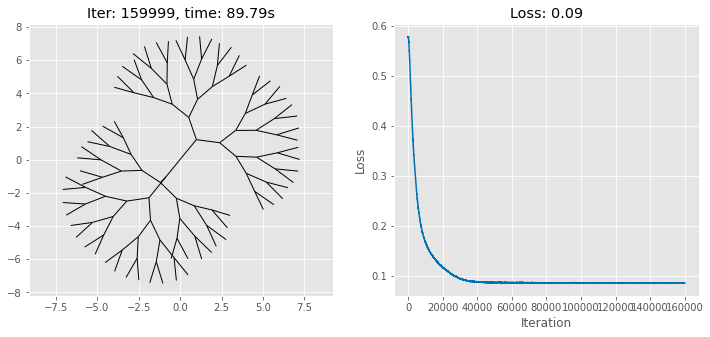

Epoch 160916: reducing learning rate of group 0 to 3.1813e-03.
Epoch 163017: reducing learning rate of group 0 to 2.8632e-03.
Epoch 165118: reducing learning rate of group 0 to 2.5769e-03.
Epoch 167219: reducing learning rate of group 0 to 2.3192e-03.
Epoch 169320: reducing learning rate of group 0 to 2.0873e-03.
Epoch 171421: reducing learning rate of group 0 to 1.8786e-03.
Epoch 173522: reducing learning rate of group 0 to 1.6907e-03.
Epoch 175623: reducing learning rate of group 0 to 1.5216e-03.
Epoch 177724: reducing learning rate of group 0 to 1.3695e-03.
Epoch 179825: reducing learning rate of group 0 to 1.2325e-03.


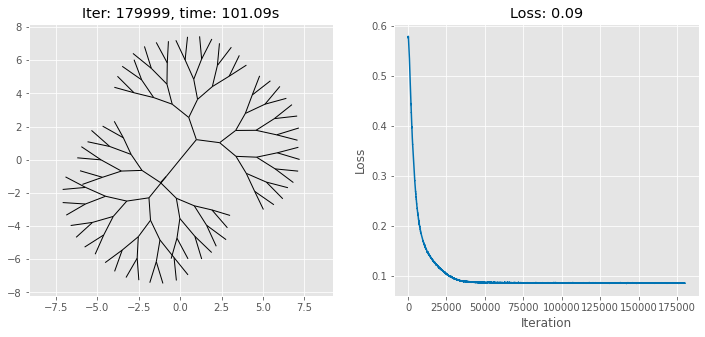

Epoch 181926: reducing learning rate of group 0 to 1.1093e-03.
Epoch 184027: reducing learning rate of group 0 to 9.9834e-04.
Epoch 186128: reducing learning rate of group 0 to 8.9851e-04.
Epoch 188229: reducing learning rate of group 0 to 8.0865e-04.
Epoch 190330: reducing learning rate of group 0 to 7.2779e-04.
Epoch 192431: reducing learning rate of group 0 to 6.5501e-04.
Epoch 194532: reducing learning rate of group 0 to 5.8951e-04.
Epoch 196633: reducing learning rate of group 0 to 5.3056e-04.
Epoch 198734: reducing learning rate of group 0 to 4.7750e-04.


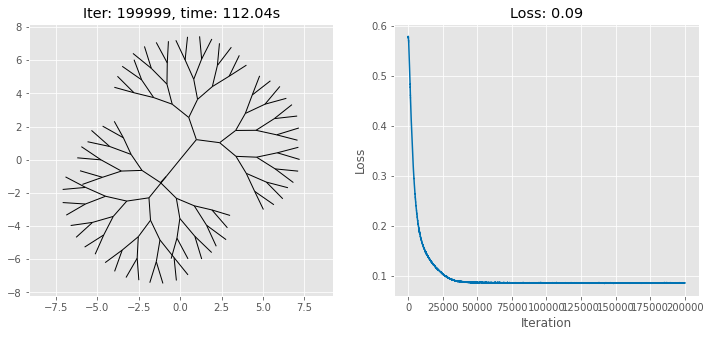

Epoch 200835: reducing learning rate of group 0 to 4.2975e-04.
Epoch 202936: reducing learning rate of group 0 to 3.8678e-04.
Epoch 205037: reducing learning rate of group 0 to 3.4810e-04.
Epoch 207138: reducing learning rate of group 0 to 3.1329e-04.
Epoch 209239: reducing learning rate of group 0 to 2.8196e-04.
Epoch 211340: reducing learning rate of group 0 to 2.5376e-04.
Epoch 213441: reducing learning rate of group 0 to 2.2839e-04.
Epoch 215542: reducing learning rate of group 0 to 2.0555e-04.
Epoch 217643: reducing learning rate of group 0 to 1.8499e-04.
Epoch 219744: reducing learning rate of group 0 to 1.6649e-04.


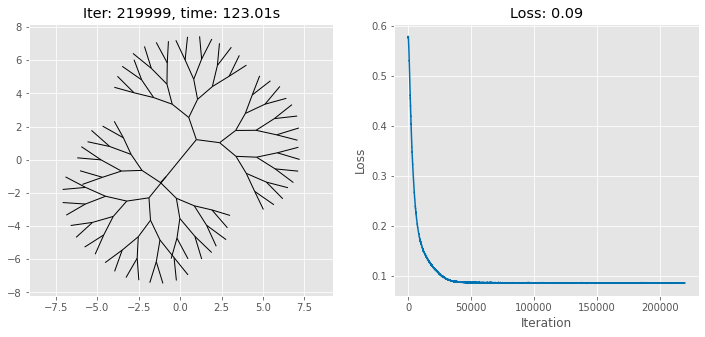

Epoch 221845: reducing learning rate of group 0 to 1.4985e-04.
Epoch 223946: reducing learning rate of group 0 to 1.3486e-04.
Epoch 226047: reducing learning rate of group 0 to 1.2137e-04.
Epoch 228148: reducing learning rate of group 0 to 1.0924e-04.
Epoch 230249: reducing learning rate of group 0 to 9.8314e-05.
Epoch 232350: reducing learning rate of group 0 to 8.8482e-05.
Epoch 234451: reducing learning rate of group 0 to 7.9634e-05.
Epoch 236552: reducing learning rate of group 0 to 7.1671e-05.
Epoch 238653: reducing learning rate of group 0 to 6.4504e-05.


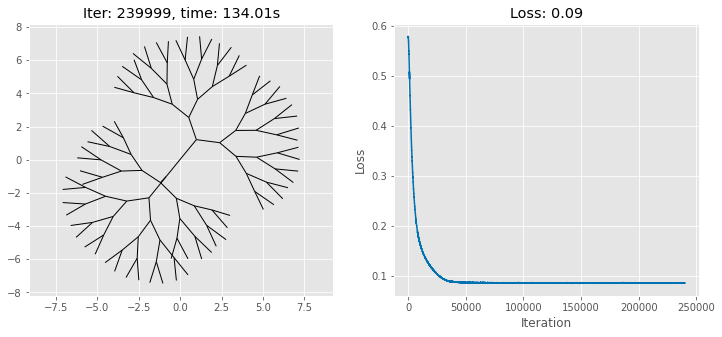

Epoch 240754: reducing learning rate of group 0 to 5.8053e-05.
Epoch 242855: reducing learning rate of group 0 to 5.2248e-05.
Epoch 244956: reducing learning rate of group 0 to 4.7023e-05.
Epoch 247057: reducing learning rate of group 0 to 4.2321e-05.
Epoch 249158: reducing learning rate of group 0 to 3.8089e-05.
Epoch 251259: reducing learning rate of group 0 to 3.4280e-05.
Epoch 253360: reducing learning rate of group 0 to 3.0852e-05.
Epoch 255461: reducing learning rate of group 0 to 2.7767e-05.
Epoch 257562: reducing learning rate of group 0 to 2.4990e-05.
Epoch 259663: reducing learning rate of group 0 to 2.2491e-05.


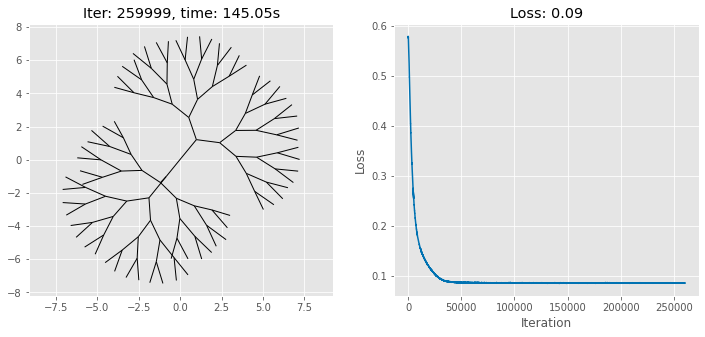

Epoch 261764: reducing learning rate of group 0 to 2.0242e-05.
Epoch 263865: reducing learning rate of group 0 to 1.8218e-05.
Epoch 265966: reducing learning rate of group 0 to 1.6396e-05.
Epoch 268067: reducing learning rate of group 0 to 1.4756e-05.
Epoch 270168: reducing learning rate of group 0 to 1.3281e-05.
Epoch 273429: reducing learning rate of group 0 to 1.1953e-05.
Epoch 275530: reducing learning rate of group 0 to 1.0757e-05.
Epoch 277631: reducing learning rate of group 0 to 1.0000e-05.



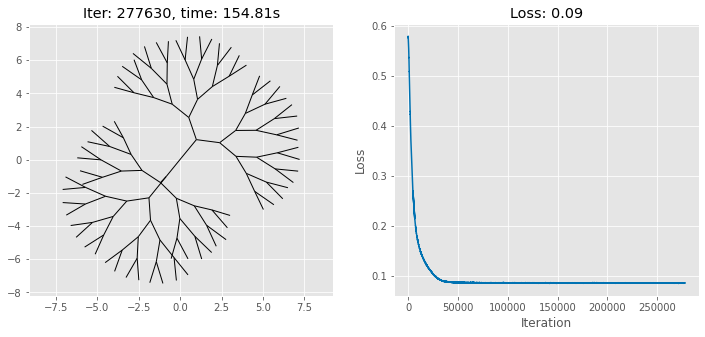

127


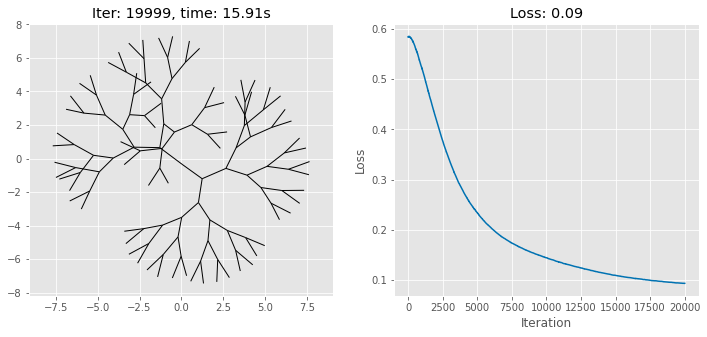

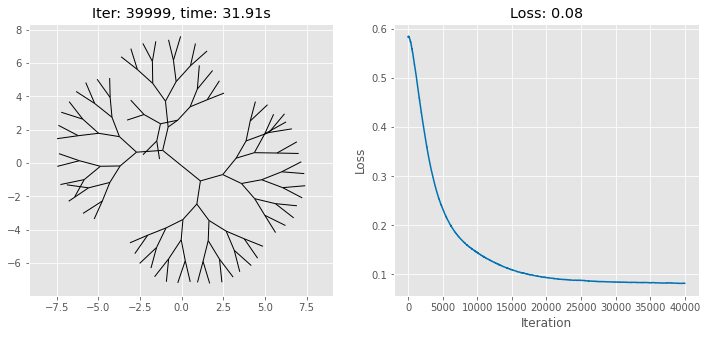

Epoch 54553: reducing learning rate of group 0 to 4.5000e-01.


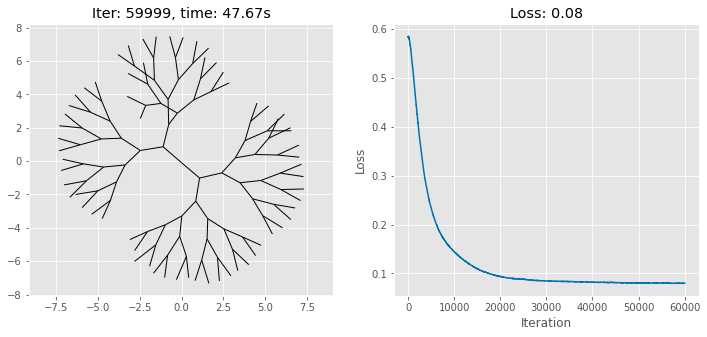

Epoch 60471: reducing learning rate of group 0 to 4.0500e-01.
Epoch 66276: reducing learning rate of group 0 to 3.6450e-01.
Epoch 73992: reducing learning rate of group 0 to 3.2805e-01.
Epoch 76093: reducing learning rate of group 0 to 2.9525e-01.


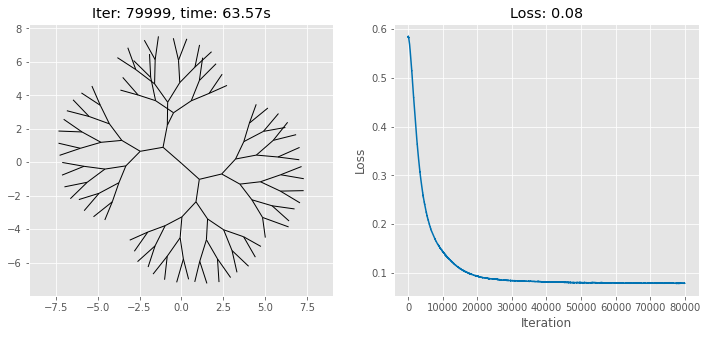

Epoch 80601: reducing learning rate of group 0 to 2.6572e-01.
Epoch 82702: reducing learning rate of group 0 to 2.3915e-01.
Epoch 84803: reducing learning rate of group 0 to 2.1523e-01.
Epoch 86904: reducing learning rate of group 0 to 1.9371e-01.
Epoch 90181: reducing learning rate of group 0 to 1.7434e-01.
Epoch 94261: reducing learning rate of group 0 to 1.5691e-01.
Epoch 96362: reducing learning rate of group 0 to 1.4121e-01.
Epoch 98463: reducing learning rate of group 0 to 1.2709e-01.


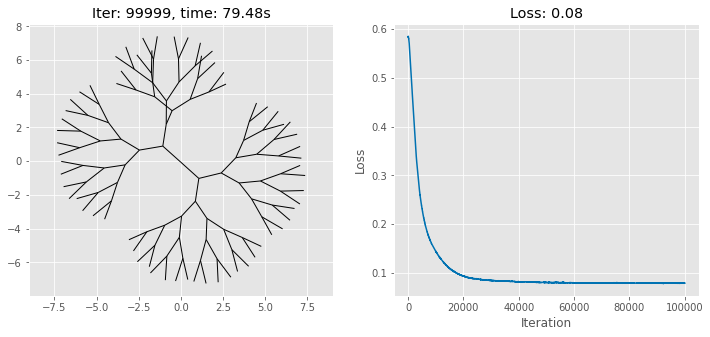

Epoch 100564: reducing learning rate of group 0 to 1.1438e-01.
Epoch 103416: reducing learning rate of group 0 to 1.0295e-01.
Epoch 105517: reducing learning rate of group 0 to 9.2651e-02.
Epoch 107618: reducing learning rate of group 0 to 8.3386e-02.
Epoch 111490: reducing learning rate of group 0 to 7.5047e-02.
Epoch 113591: reducing learning rate of group 0 to 6.7543e-02.
Epoch 115692: reducing learning rate of group 0 to 6.0788e-02.
Epoch 117793: reducing learning rate of group 0 to 5.4709e-02.
Epoch 119894: reducing learning rate of group 0 to 4.9239e-02.


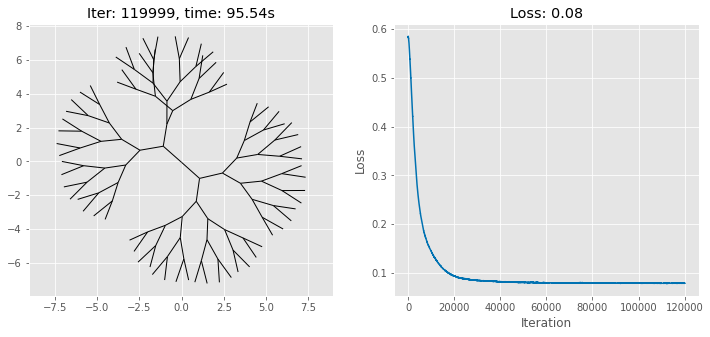

Epoch 121995: reducing learning rate of group 0 to 4.4315e-02.
Epoch 124096: reducing learning rate of group 0 to 3.9883e-02.
Epoch 126197: reducing learning rate of group 0 to 3.5895e-02.
Epoch 128298: reducing learning rate of group 0 to 3.2305e-02.
Epoch 130399: reducing learning rate of group 0 to 2.9075e-02.
Epoch 132500: reducing learning rate of group 0 to 2.6167e-02.
Epoch 134601: reducing learning rate of group 0 to 2.3551e-02.
Epoch 136702: reducing learning rate of group 0 to 2.1196e-02.
Epoch 138803: reducing learning rate of group 0 to 1.9076e-02.


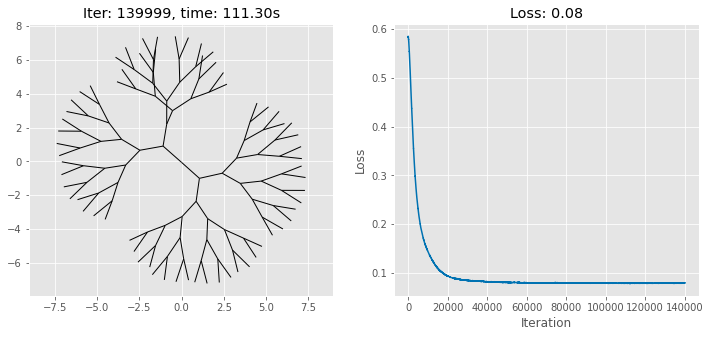

Epoch 140904: reducing learning rate of group 0 to 1.7168e-02.
Epoch 143005: reducing learning rate of group 0 to 1.5452e-02.
Epoch 145106: reducing learning rate of group 0 to 1.3906e-02.
Epoch 147207: reducing learning rate of group 0 to 1.2516e-02.
Epoch 149308: reducing learning rate of group 0 to 1.1264e-02.
Epoch 151409: reducing learning rate of group 0 to 1.0138e-02.
Epoch 153510: reducing learning rate of group 0 to 9.1240e-03.
Epoch 155611: reducing learning rate of group 0 to 8.2116e-03.
Epoch 157712: reducing learning rate of group 0 to 7.3904e-03.
Epoch 159813: reducing learning rate of group 0 to 6.6514e-03.


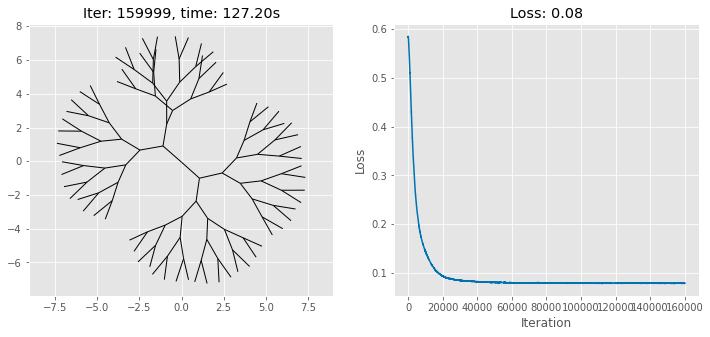

Epoch 162596: reducing learning rate of group 0 to 5.9863e-03.
Epoch 164697: reducing learning rate of group 0 to 5.3876e-03.
Epoch 166798: reducing learning rate of group 0 to 4.8489e-03.
Epoch 168899: reducing learning rate of group 0 to 4.3640e-03.
Epoch 172000: reducing learning rate of group 0 to 3.9276e-03.
Epoch 174101: reducing learning rate of group 0 to 3.5348e-03.
Epoch 176202: reducing learning rate of group 0 to 3.1813e-03.
Epoch 178303: reducing learning rate of group 0 to 2.8632e-03.


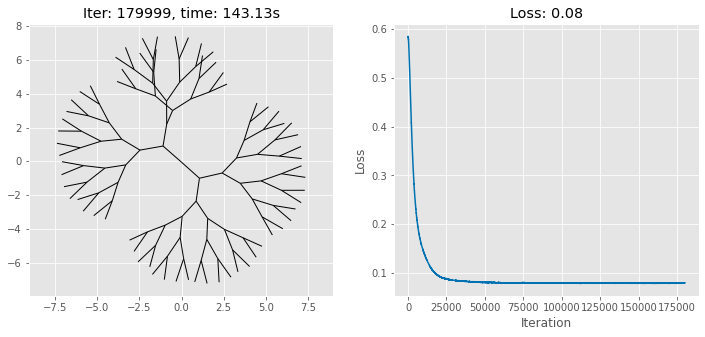

Epoch 180404: reducing learning rate of group 0 to 2.5769e-03.
Epoch 182505: reducing learning rate of group 0 to 2.3192e-03.
Epoch 184606: reducing learning rate of group 0 to 2.0873e-03.
Epoch 186707: reducing learning rate of group 0 to 1.8786e-03.
Epoch 188808: reducing learning rate of group 0 to 1.6907e-03.
Epoch 191446: reducing learning rate of group 0 to 1.5216e-03.
Epoch 193547: reducing learning rate of group 0 to 1.3695e-03.
Epoch 195648: reducing learning rate of group 0 to 1.2325e-03.
Epoch 197749: reducing learning rate of group 0 to 1.1093e-03.


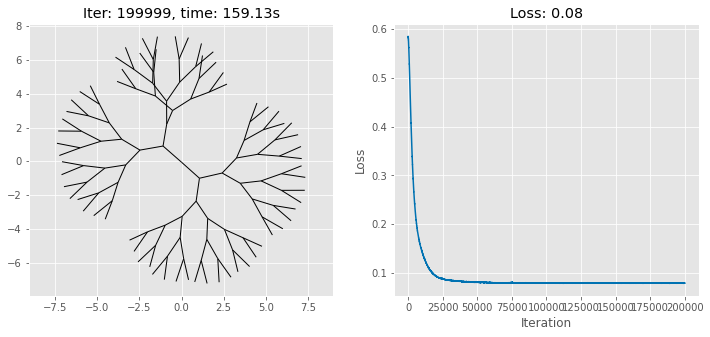

Epoch 201291: reducing learning rate of group 0 to 9.9834e-04.
Epoch 203392: reducing learning rate of group 0 to 8.9851e-04.
Epoch 205493: reducing learning rate of group 0 to 8.0865e-04.
Epoch 207594: reducing learning rate of group 0 to 7.2779e-04.
Epoch 209695: reducing learning rate of group 0 to 6.5501e-04.
Epoch 211796: reducing learning rate of group 0 to 5.8951e-04.
Epoch 213897: reducing learning rate of group 0 to 5.3056e-04.
Epoch 215998: reducing learning rate of group 0 to 4.7750e-04.
Epoch 218099: reducing learning rate of group 0 to 4.2975e-04.


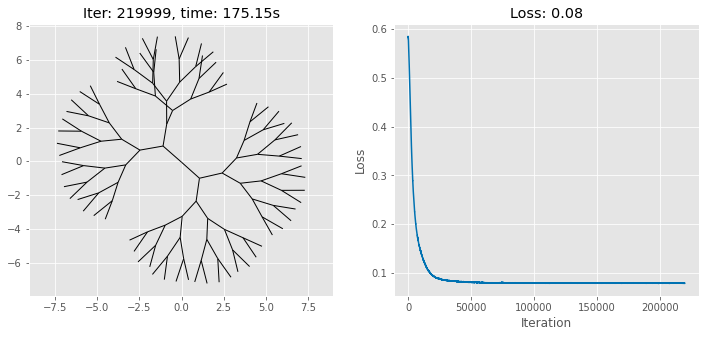

Epoch 220200: reducing learning rate of group 0 to 3.8678e-04.
Epoch 222301: reducing learning rate of group 0 to 3.4810e-04.
Epoch 224402: reducing learning rate of group 0 to 3.1329e-04.
Epoch 226503: reducing learning rate of group 0 to 2.8196e-04.
Epoch 228604: reducing learning rate of group 0 to 2.5376e-04.
Epoch 230705: reducing learning rate of group 0 to 2.2839e-04.
Epoch 232806: reducing learning rate of group 0 to 2.0555e-04.
Epoch 234907: reducing learning rate of group 0 to 1.8499e-04.
Epoch 237008: reducing learning rate of group 0 to 1.6649e-04.
Epoch 239109: reducing learning rate of group 0 to 1.4985e-04.


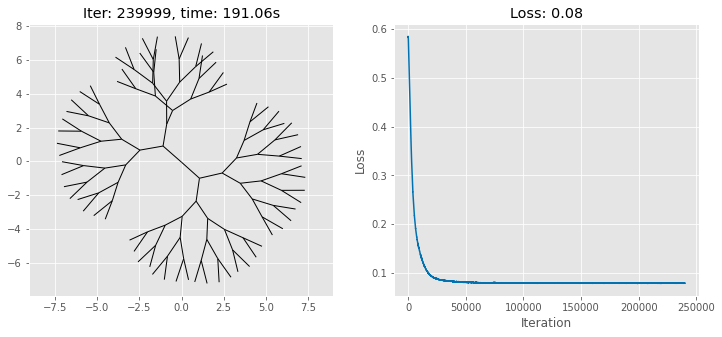

Epoch 241210: reducing learning rate of group 0 to 1.3486e-04.
Epoch 243311: reducing learning rate of group 0 to 1.2137e-04.
Epoch 245412: reducing learning rate of group 0 to 1.0924e-04.
Epoch 247513: reducing learning rate of group 0 to 9.8314e-05.
Epoch 249614: reducing learning rate of group 0 to 8.8482e-05.
Epoch 251715: reducing learning rate of group 0 to 7.9634e-05.
Epoch 253816: reducing learning rate of group 0 to 7.1671e-05.
Epoch 255917: reducing learning rate of group 0 to 6.4504e-05.
Epoch 258018: reducing learning rate of group 0 to 5.8053e-05.


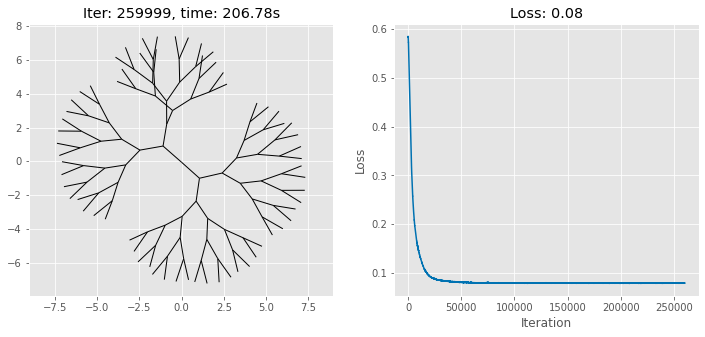

Epoch 260119: reducing learning rate of group 0 to 5.2248e-05.
Epoch 262220: reducing learning rate of group 0 to 4.7023e-05.
Epoch 264321: reducing learning rate of group 0 to 4.2321e-05.
Epoch 266422: reducing learning rate of group 0 to 3.8089e-05.
Epoch 268523: reducing learning rate of group 0 to 3.4280e-05.
Epoch 270624: reducing learning rate of group 0 to 3.0852e-05.
Epoch 272725: reducing learning rate of group 0 to 2.7767e-05.
Epoch 274826: reducing learning rate of group 0 to 2.4990e-05.
Epoch 276927: reducing learning rate of group 0 to 2.2491e-05.
Epoch 279028: reducing learning rate of group 0 to 2.0242e-05.


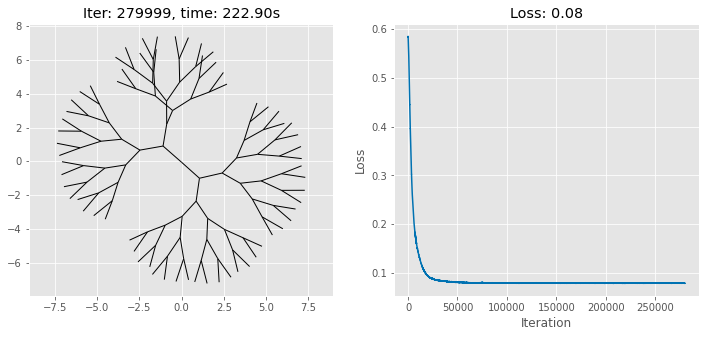

Epoch 281129: reducing learning rate of group 0 to 1.8218e-05.
Epoch 283230: reducing learning rate of group 0 to 1.6396e-05.
Epoch 285331: reducing learning rate of group 0 to 1.4756e-05.
Epoch 287432: reducing learning rate of group 0 to 1.3281e-05.
Epoch 289533: reducing learning rate of group 0 to 1.1953e-05.
Epoch 291634: reducing learning rate of group 0 to 1.0757e-05.
Epoch 293735: reducing learning rate of group 0 to 1.0000e-05.



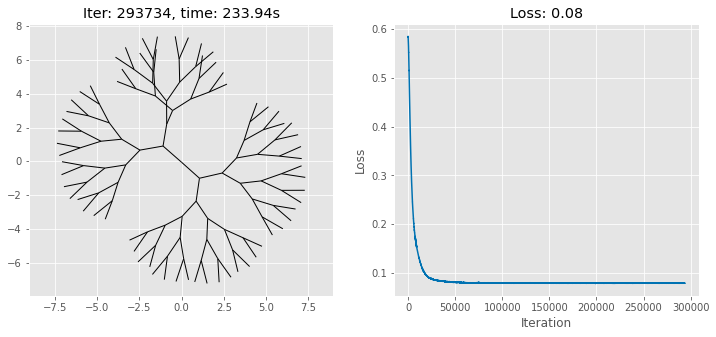

127


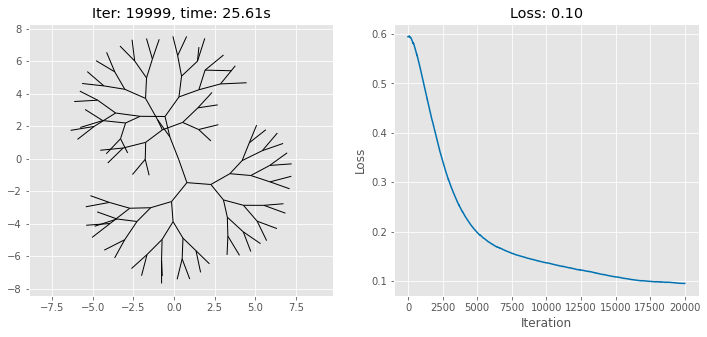

Epoch 31525: reducing learning rate of group 0 to 4.5000e-01.
Epoch 35523: reducing learning rate of group 0 to 4.0500e-01.


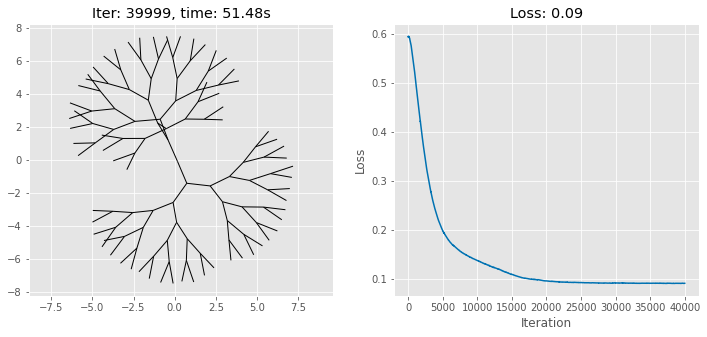

Epoch 40593: reducing learning rate of group 0 to 3.6450e-01.
Epoch 44804: reducing learning rate of group 0 to 3.2805e-01.
Epoch 46905: reducing learning rate of group 0 to 2.9525e-01.
Epoch 49006: reducing learning rate of group 0 to 2.6572e-01.
Epoch 51107: reducing learning rate of group 0 to 2.3915e-01.
Epoch 56241: reducing learning rate of group 0 to 2.1523e-01.
Epoch 58342: reducing learning rate of group 0 to 1.9371e-01.


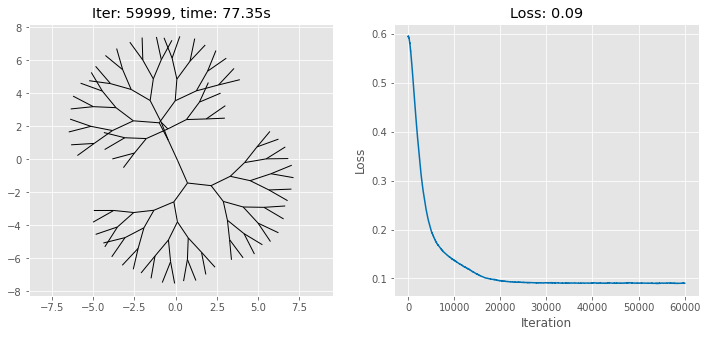

Epoch 60443: reducing learning rate of group 0 to 1.7434e-01.
Epoch 62544: reducing learning rate of group 0 to 1.5691e-01.
Epoch 64645: reducing learning rate of group 0 to 1.4121e-01.
Epoch 66746: reducing learning rate of group 0 to 1.2709e-01.
Epoch 68847: reducing learning rate of group 0 to 1.1438e-01.
Epoch 70948: reducing learning rate of group 0 to 1.0295e-01.
Epoch 73049: reducing learning rate of group 0 to 9.2651e-02.
Epoch 75150: reducing learning rate of group 0 to 8.3386e-02.
Epoch 77251: reducing learning rate of group 0 to 7.5047e-02.


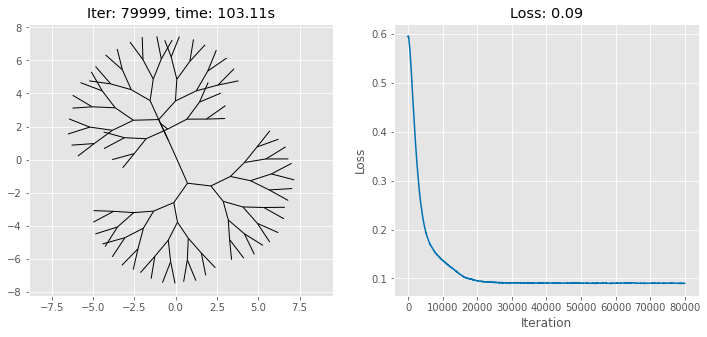

Epoch 81383: reducing learning rate of group 0 to 6.7543e-02.
Epoch 83484: reducing learning rate of group 0 to 6.0788e-02.
Epoch 85585: reducing learning rate of group 0 to 5.4709e-02.
Epoch 87686: reducing learning rate of group 0 to 4.9239e-02.
Epoch 89787: reducing learning rate of group 0 to 4.4315e-02.
Epoch 91888: reducing learning rate of group 0 to 3.9883e-02.
Epoch 93989: reducing learning rate of group 0 to 3.5895e-02.
Epoch 96090: reducing learning rate of group 0 to 3.2305e-02.
Epoch 98191: reducing learning rate of group 0 to 2.9075e-02.


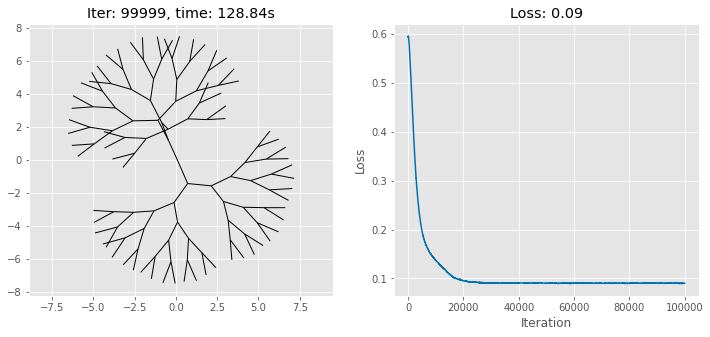

Epoch 100695: reducing learning rate of group 0 to 2.6167e-02.
Epoch 102796: reducing learning rate of group 0 to 2.3551e-02.
Epoch 104897: reducing learning rate of group 0 to 2.1196e-02.
Epoch 109102: reducing learning rate of group 0 to 1.9076e-02.
Epoch 111203: reducing learning rate of group 0 to 1.7168e-02.
Epoch 113304: reducing learning rate of group 0 to 1.5452e-02.
Epoch 115405: reducing learning rate of group 0 to 1.3906e-02.
Epoch 117506: reducing learning rate of group 0 to 1.2516e-02.
Epoch 119607: reducing learning rate of group 0 to 1.1264e-02.


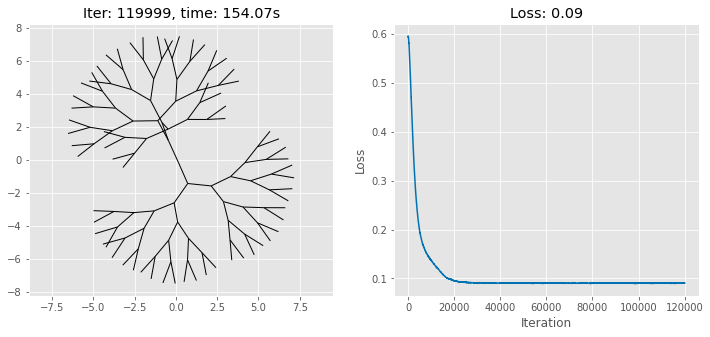

Epoch 121708: reducing learning rate of group 0 to 1.0138e-02.
Epoch 123809: reducing learning rate of group 0 to 9.1240e-03.
Epoch 125910: reducing learning rate of group 0 to 8.2116e-03.
Epoch 128011: reducing learning rate of group 0 to 7.3904e-03.
Epoch 130112: reducing learning rate of group 0 to 6.6514e-03.
Epoch 132213: reducing learning rate of group 0 to 5.9863e-03.
Epoch 135369: reducing learning rate of group 0 to 5.3876e-03.
Epoch 137470: reducing learning rate of group 0 to 4.8489e-03.
Epoch 139571: reducing learning rate of group 0 to 4.3640e-03.


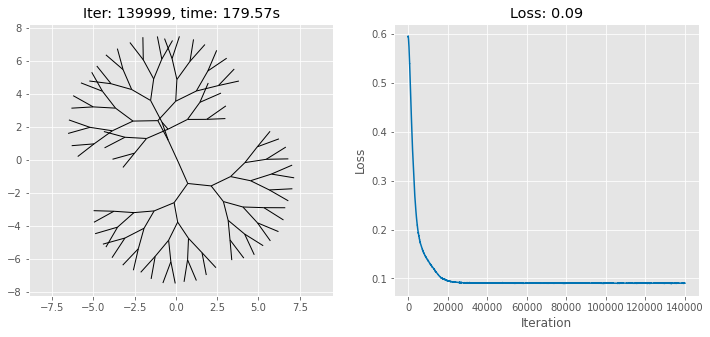

Epoch 141672: reducing learning rate of group 0 to 3.9276e-03.
Epoch 143773: reducing learning rate of group 0 to 3.5348e-03.
Epoch 145874: reducing learning rate of group 0 to 3.1813e-03.
Epoch 147975: reducing learning rate of group 0 to 2.8632e-03.
Epoch 150076: reducing learning rate of group 0 to 2.5769e-03.
Epoch 152177: reducing learning rate of group 0 to 2.3192e-03.
Epoch 154278: reducing learning rate of group 0 to 2.0873e-03.
Epoch 156379: reducing learning rate of group 0 to 1.8786e-03.
Epoch 158480: reducing learning rate of group 0 to 1.6907e-03.


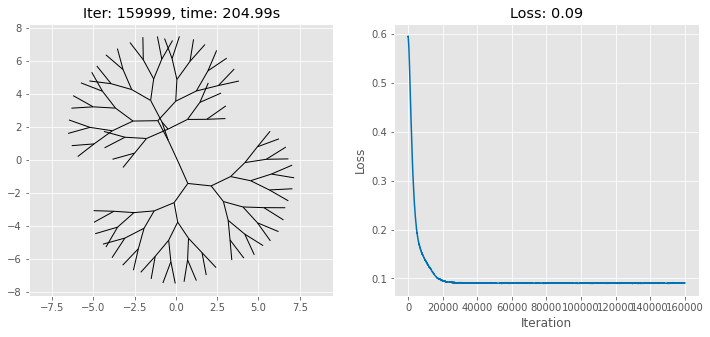

Epoch 160581: reducing learning rate of group 0 to 1.5216e-03.
Epoch 162682: reducing learning rate of group 0 to 1.3695e-03.
Epoch 164783: reducing learning rate of group 0 to 1.2325e-03.
Epoch 166884: reducing learning rate of group 0 to 1.1093e-03.
Epoch 168985: reducing learning rate of group 0 to 9.9834e-04.
Epoch 171086: reducing learning rate of group 0 to 8.9851e-04.
Epoch 173187: reducing learning rate of group 0 to 8.0865e-04.
Epoch 175368: reducing learning rate of group 0 to 7.2779e-04.
Epoch 177469: reducing learning rate of group 0 to 6.5501e-04.
Epoch 179570: reducing learning rate of group 0 to 5.8951e-04.


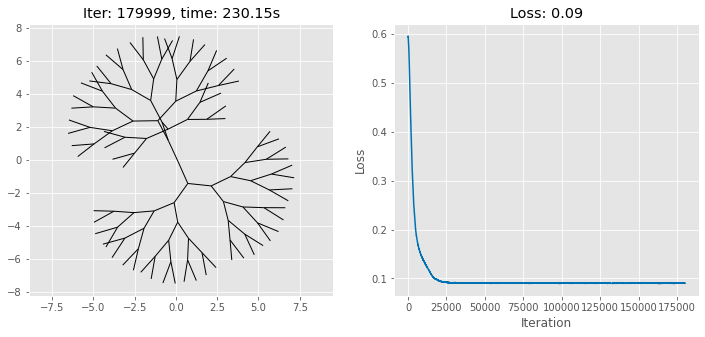

Epoch 181671: reducing learning rate of group 0 to 5.3056e-04.
Epoch 183772: reducing learning rate of group 0 to 4.7750e-04.
Epoch 185873: reducing learning rate of group 0 to 4.2975e-04.
Epoch 188069: reducing learning rate of group 0 to 3.8678e-04.
Epoch 190170: reducing learning rate of group 0 to 3.4810e-04.
Epoch 192271: reducing learning rate of group 0 to 3.1329e-04.
Epoch 194372: reducing learning rate of group 0 to 2.8196e-04.
Epoch 196473: reducing learning rate of group 0 to 2.5376e-04.
Epoch 198574: reducing learning rate of group 0 to 2.2839e-04.


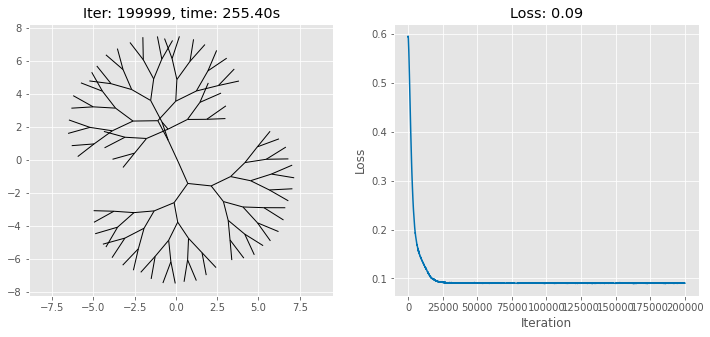

Epoch 200675: reducing learning rate of group 0 to 2.0555e-04.
Epoch 202776: reducing learning rate of group 0 to 1.8499e-04.
Epoch 204944: reducing learning rate of group 0 to 1.6649e-04.
Epoch 207045: reducing learning rate of group 0 to 1.4985e-04.
Epoch 209146: reducing learning rate of group 0 to 1.3486e-04.
Epoch 211247: reducing learning rate of group 0 to 1.2137e-04.
Epoch 213348: reducing learning rate of group 0 to 1.0924e-04.
Epoch 215449: reducing learning rate of group 0 to 9.8314e-05.
Epoch 217550: reducing learning rate of group 0 to 8.8482e-05.
Epoch 219651: reducing learning rate of group 0 to 7.9634e-05.


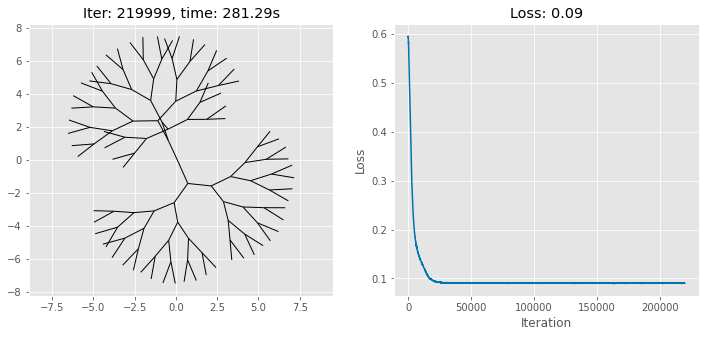

Epoch 221752: reducing learning rate of group 0 to 7.1671e-05.
Epoch 223853: reducing learning rate of group 0 to 6.4504e-05.
Epoch 225954: reducing learning rate of group 0 to 5.8053e-05.
Epoch 228055: reducing learning rate of group 0 to 5.2248e-05.
Epoch 230156: reducing learning rate of group 0 to 4.7023e-05.
Epoch 232257: reducing learning rate of group 0 to 4.2321e-05.
Epoch 234358: reducing learning rate of group 0 to 3.8089e-05.
Epoch 236459: reducing learning rate of group 0 to 3.4280e-05.
Epoch 238560: reducing learning rate of group 0 to 3.0852e-05.


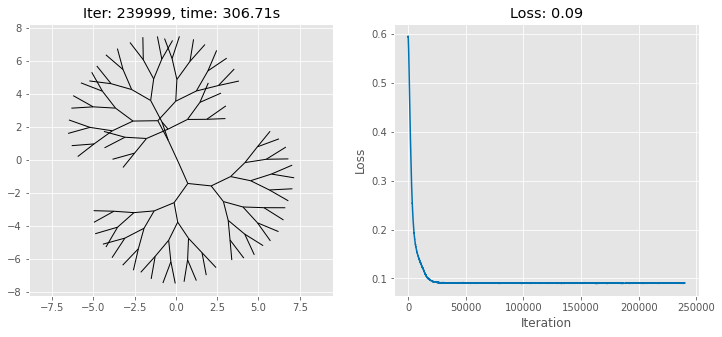

Epoch 240661: reducing learning rate of group 0 to 2.7767e-05.
Epoch 242762: reducing learning rate of group 0 to 2.4990e-05.
Epoch 245114: reducing learning rate of group 0 to 2.2491e-05.
Epoch 247215: reducing learning rate of group 0 to 2.0242e-05.
Epoch 249316: reducing learning rate of group 0 to 1.8218e-05.
Epoch 251417: reducing learning rate of group 0 to 1.6396e-05.
Epoch 253518: reducing learning rate of group 0 to 1.4756e-05.
Epoch 255619: reducing learning rate of group 0 to 1.3281e-05.
Epoch 257720: reducing learning rate of group 0 to 1.1953e-05.
Epoch 259821: reducing learning rate of group 0 to 1.0757e-05.


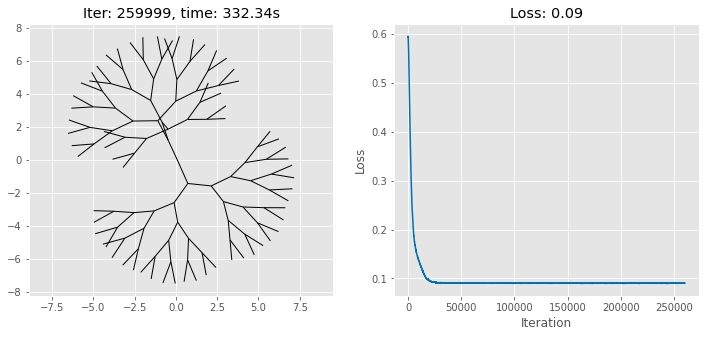

Epoch 261922: reducing learning rate of group 0 to 1.0000e-05.



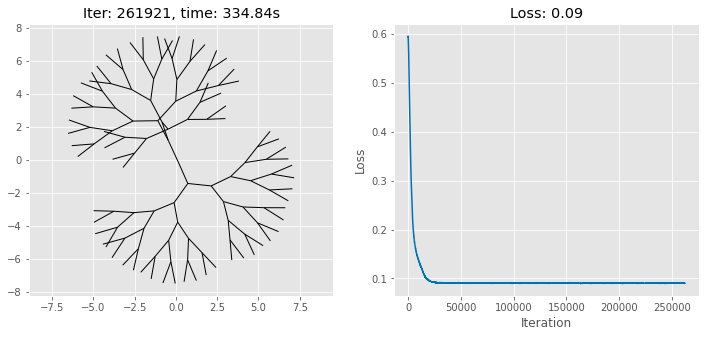

127


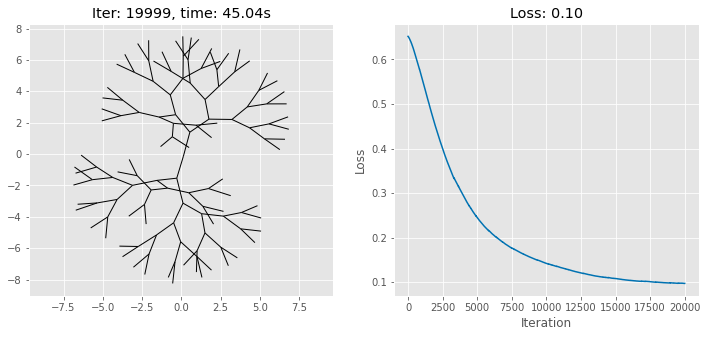

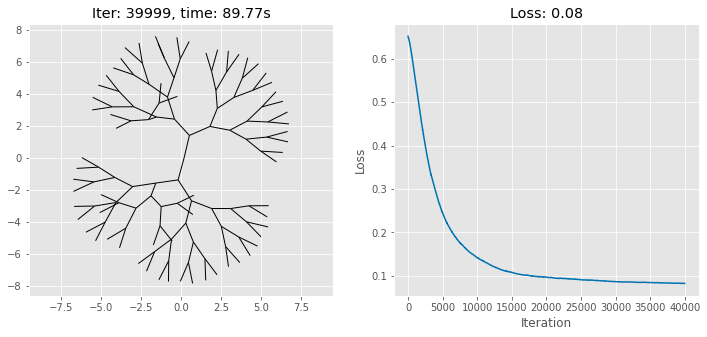

Epoch 54587: reducing learning rate of group 0 to 4.5000e-01.
Epoch 57269: reducing learning rate of group 0 to 4.0500e-01.


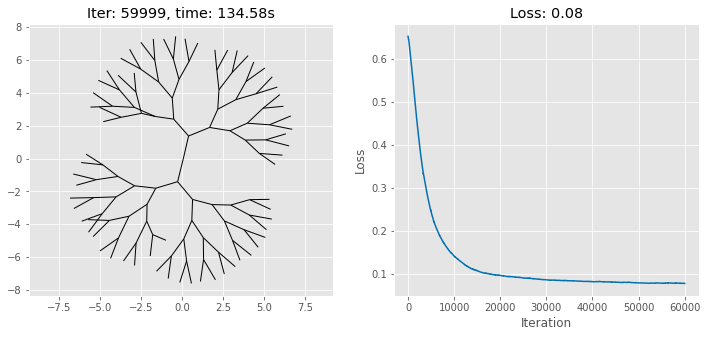

Epoch 62069: reducing learning rate of group 0 to 3.6450e-01.
Epoch 65080: reducing learning rate of group 0 to 3.2805e-01.
Epoch 67181: reducing learning rate of group 0 to 2.9525e-01.
Epoch 72565: reducing learning rate of group 0 to 2.6572e-01.
Epoch 74666: reducing learning rate of group 0 to 2.3915e-01.
Epoch 76767: reducing learning rate of group 0 to 2.1523e-01.
Epoch 79437: reducing learning rate of group 0 to 1.9371e-01.


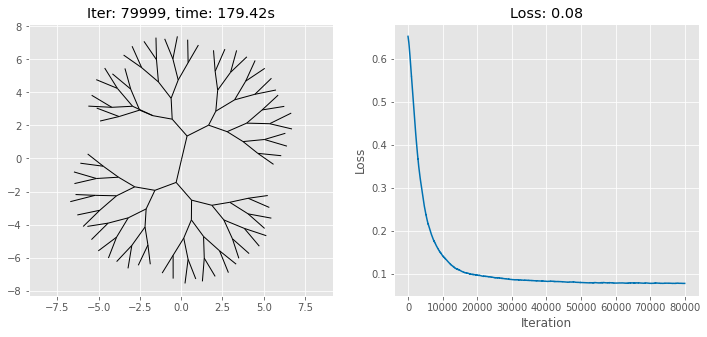

Epoch 81538: reducing learning rate of group 0 to 1.7434e-01.
Epoch 83639: reducing learning rate of group 0 to 1.5691e-01.
Epoch 85740: reducing learning rate of group 0 to 1.4121e-01.
Epoch 87841: reducing learning rate of group 0 to 1.2709e-01.
Epoch 89942: reducing learning rate of group 0 to 1.1438e-01.
Epoch 92043: reducing learning rate of group 0 to 1.0295e-01.
Epoch 94144: reducing learning rate of group 0 to 9.2651e-02.
Epoch 96245: reducing learning rate of group 0 to 8.3386e-02.


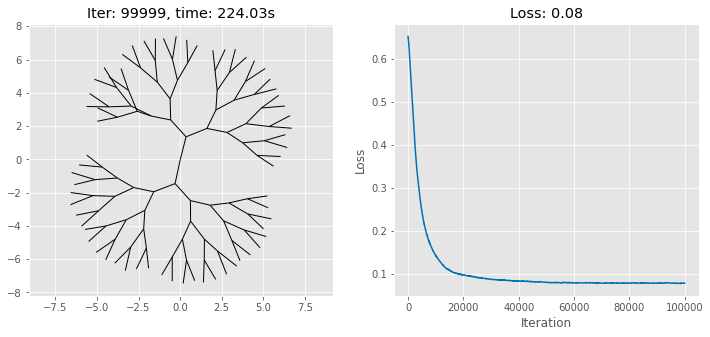

Epoch 100611: reducing learning rate of group 0 to 7.5047e-02.
Epoch 102712: reducing learning rate of group 0 to 6.7543e-02.
Epoch 104813: reducing learning rate of group 0 to 6.0788e-02.
Epoch 106914: reducing learning rate of group 0 to 5.4709e-02.
Epoch 109015: reducing learning rate of group 0 to 4.9239e-02.
Epoch 111116: reducing learning rate of group 0 to 4.4315e-02.
Epoch 113217: reducing learning rate of group 0 to 3.9883e-02.
Epoch 115318: reducing learning rate of group 0 to 3.5895e-02.
Epoch 117419: reducing learning rate of group 0 to 3.2305e-02.
Epoch 119520: reducing learning rate of group 0 to 2.9075e-02.


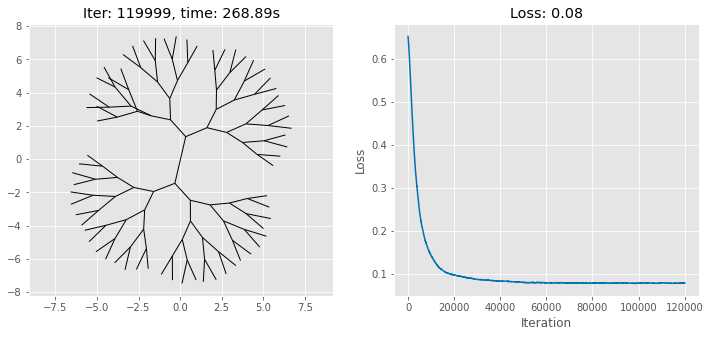

Epoch 121621: reducing learning rate of group 0 to 2.6167e-02.
Epoch 123722: reducing learning rate of group 0 to 2.3551e-02.
Epoch 125823: reducing learning rate of group 0 to 2.1196e-02.
Epoch 127924: reducing learning rate of group 0 to 1.9076e-02.
Epoch 130025: reducing learning rate of group 0 to 1.7168e-02.
Epoch 132126: reducing learning rate of group 0 to 1.5452e-02.
Epoch 134227: reducing learning rate of group 0 to 1.3906e-02.
Epoch 136328: reducing learning rate of group 0 to 1.2516e-02.
Epoch 138429: reducing learning rate of group 0 to 1.1264e-02.


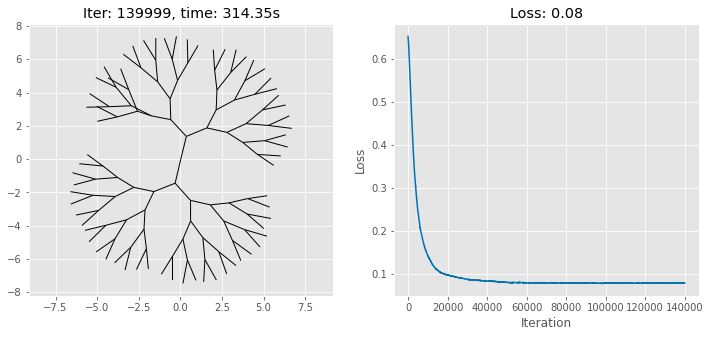

Epoch 140530: reducing learning rate of group 0 to 1.0138e-02.
Epoch 142631: reducing learning rate of group 0 to 9.1240e-03.
Epoch 144732: reducing learning rate of group 0 to 8.2116e-03.
Epoch 146833: reducing learning rate of group 0 to 7.3904e-03.
Epoch 148934: reducing learning rate of group 0 to 6.6514e-03.
Epoch 151035: reducing learning rate of group 0 to 5.9863e-03.
Epoch 153136: reducing learning rate of group 0 to 5.3876e-03.
Epoch 155237: reducing learning rate of group 0 to 4.8489e-03.
Epoch 157338: reducing learning rate of group 0 to 4.3640e-03.
Epoch 159439: reducing learning rate of group 0 to 3.9276e-03.


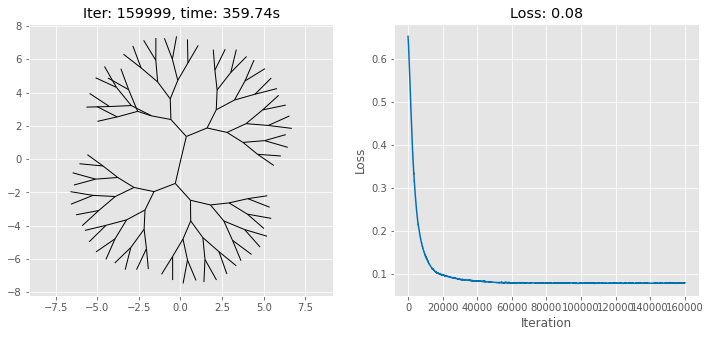

Epoch 161540: reducing learning rate of group 0 to 3.5348e-03.
Epoch 163641: reducing learning rate of group 0 to 3.1813e-03.
Epoch 165742: reducing learning rate of group 0 to 2.8632e-03.
Epoch 167843: reducing learning rate of group 0 to 2.5769e-03.
Epoch 169944: reducing learning rate of group 0 to 2.3192e-03.
Epoch 172045: reducing learning rate of group 0 to 2.0873e-03.
Epoch 174146: reducing learning rate of group 0 to 1.8786e-03.
Epoch 176247: reducing learning rate of group 0 to 1.6907e-03.
Epoch 178348: reducing learning rate of group 0 to 1.5216e-03.


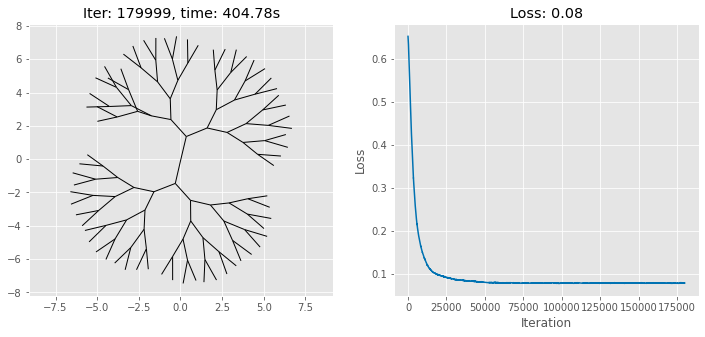

Epoch 180449: reducing learning rate of group 0 to 1.3695e-03.
Epoch 182550: reducing learning rate of group 0 to 1.2325e-03.
Epoch 184651: reducing learning rate of group 0 to 1.1093e-03.
Epoch 186752: reducing learning rate of group 0 to 9.9834e-04.
Epoch 188853: reducing learning rate of group 0 to 8.9851e-04.
Epoch 190954: reducing learning rate of group 0 to 8.0865e-04.
Epoch 193055: reducing learning rate of group 0 to 7.2779e-04.
Epoch 195156: reducing learning rate of group 0 to 6.5501e-04.
Epoch 197257: reducing learning rate of group 0 to 5.8951e-04.
Epoch 199358: reducing learning rate of group 0 to 5.3056e-04.


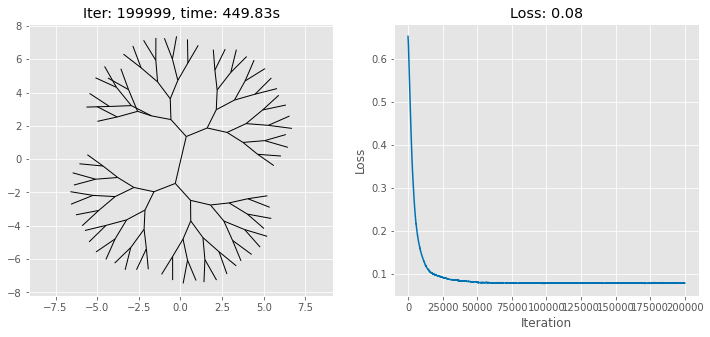

Epoch 201459: reducing learning rate of group 0 to 4.7750e-04.
Epoch 203560: reducing learning rate of group 0 to 4.2975e-04.
Epoch 205661: reducing learning rate of group 0 to 3.8678e-04.
Epoch 207762: reducing learning rate of group 0 to 3.4810e-04.
Epoch 209863: reducing learning rate of group 0 to 3.1329e-04.
Epoch 211964: reducing learning rate of group 0 to 2.8196e-04.
Epoch 214065: reducing learning rate of group 0 to 2.5376e-04.
Epoch 216166: reducing learning rate of group 0 to 2.2839e-04.
Epoch 218267: reducing learning rate of group 0 to 2.0555e-04.


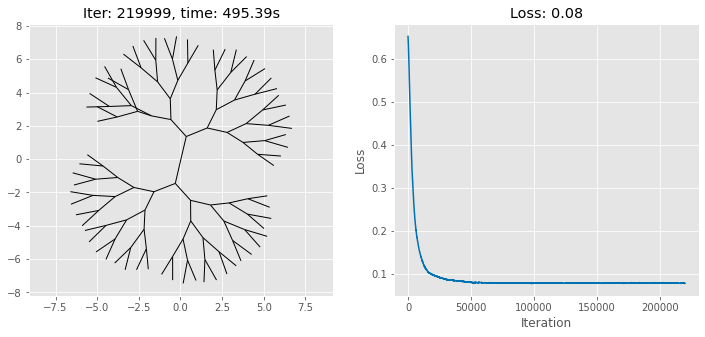

Epoch 220368: reducing learning rate of group 0 to 1.8499e-04.
Epoch 222469: reducing learning rate of group 0 to 1.6649e-04.
Epoch 224570: reducing learning rate of group 0 to 1.4985e-04.
Epoch 226671: reducing learning rate of group 0 to 1.3486e-04.
Epoch 228772: reducing learning rate of group 0 to 1.2137e-04.
Epoch 230873: reducing learning rate of group 0 to 1.0924e-04.
Epoch 232974: reducing learning rate of group 0 to 9.8314e-05.
Epoch 235075: reducing learning rate of group 0 to 8.8482e-05.
Epoch 237176: reducing learning rate of group 0 to 7.9634e-05.
Epoch 239277: reducing learning rate of group 0 to 7.1671e-05.


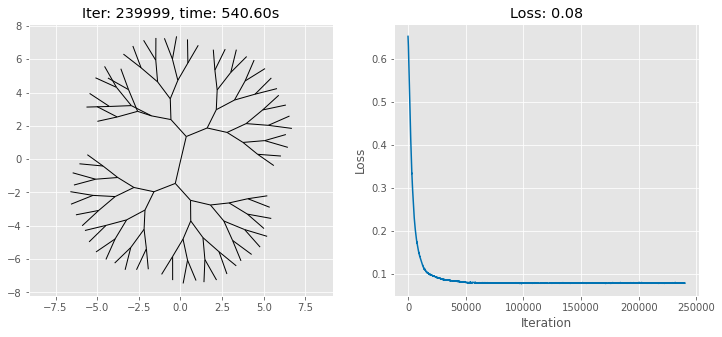

Epoch 241378: reducing learning rate of group 0 to 6.4504e-05.
Epoch 243479: reducing learning rate of group 0 to 5.8053e-05.
Epoch 245580: reducing learning rate of group 0 to 5.2248e-05.
Epoch 247681: reducing learning rate of group 0 to 4.7023e-05.
Epoch 249782: reducing learning rate of group 0 to 4.2321e-05.
Epoch 251883: reducing learning rate of group 0 to 3.8089e-05.
Epoch 253984: reducing learning rate of group 0 to 3.4280e-05.
Epoch 256085: reducing learning rate of group 0 to 3.0852e-05.
Epoch 258186: reducing learning rate of group 0 to 2.7767e-05.


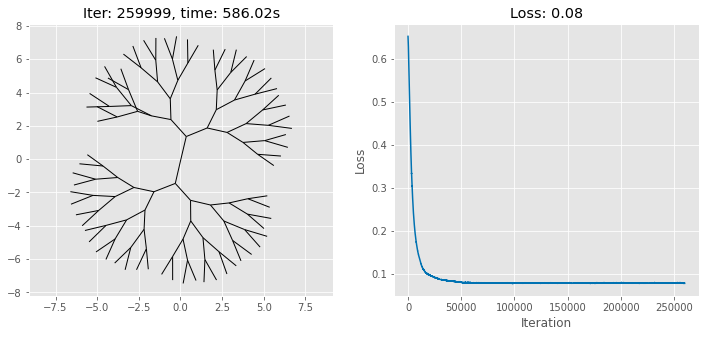

Epoch 260287: reducing learning rate of group 0 to 2.4990e-05.
Epoch 262388: reducing learning rate of group 0 to 2.2491e-05.
Epoch 264489: reducing learning rate of group 0 to 2.0242e-05.
Epoch 266590: reducing learning rate of group 0 to 1.8218e-05.
Epoch 268691: reducing learning rate of group 0 to 1.6396e-05.
Epoch 270792: reducing learning rate of group 0 to 1.4756e-05.
Epoch 272893: reducing learning rate of group 0 to 1.3281e-05.
Epoch 274994: reducing learning rate of group 0 to 1.1953e-05.
Epoch 277095: reducing learning rate of group 0 to 1.0757e-05.
Epoch 279196: reducing learning rate of group 0 to 1.0000e-05.



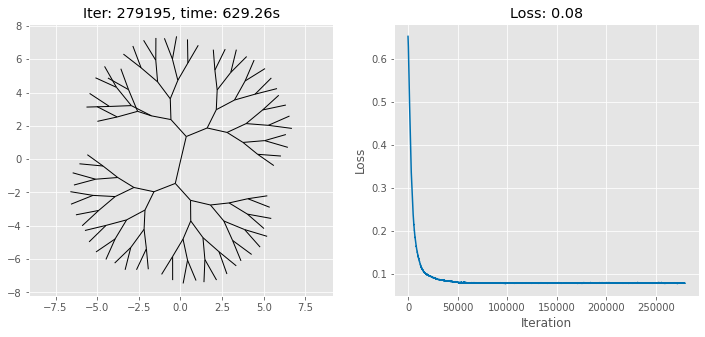

127


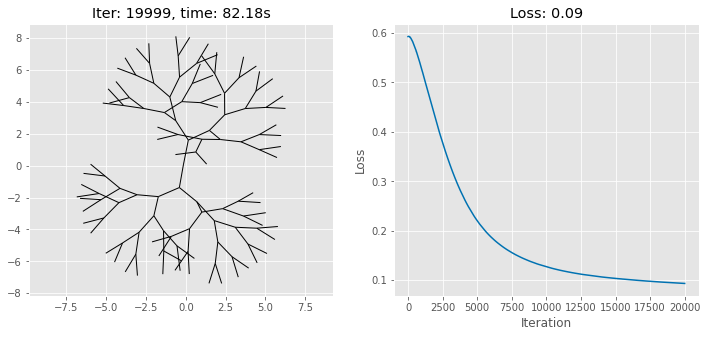

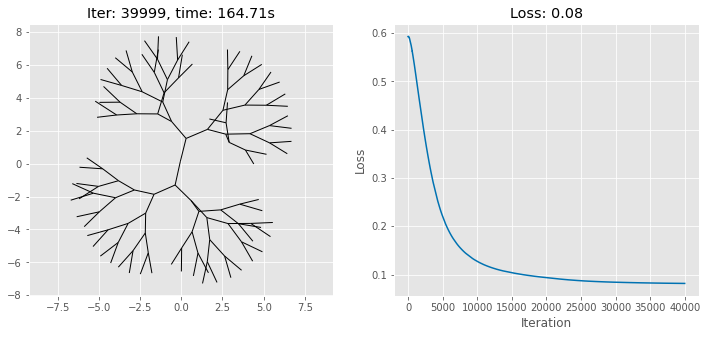

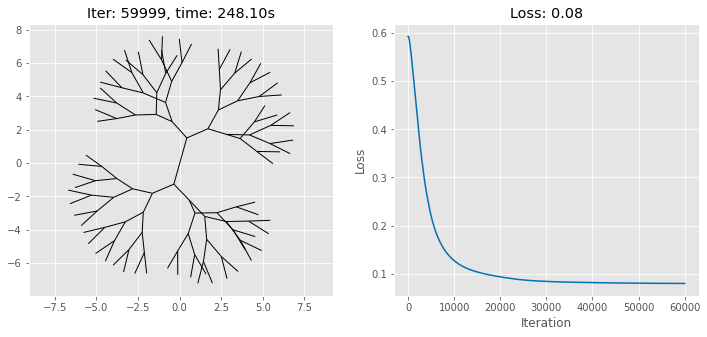

Epoch 66349: reducing learning rate of group 0 to 4.5000e-01.
Epoch 73030: reducing learning rate of group 0 to 4.0500e-01.
Epoch 76862: reducing learning rate of group 0 to 3.6450e-01.


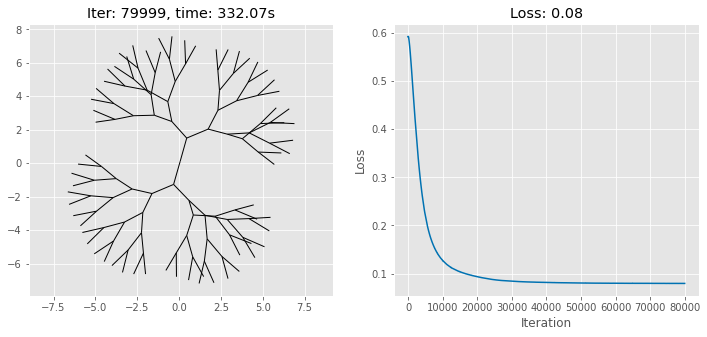

Epoch 82815: reducing learning rate of group 0 to 3.2805e-01.
Epoch 88095: reducing learning rate of group 0 to 2.9525e-01.
Epoch 90196: reducing learning rate of group 0 to 2.6572e-01.
Epoch 93698: reducing learning rate of group 0 to 2.3915e-01.
Epoch 96541: reducing learning rate of group 0 to 2.1523e-01.


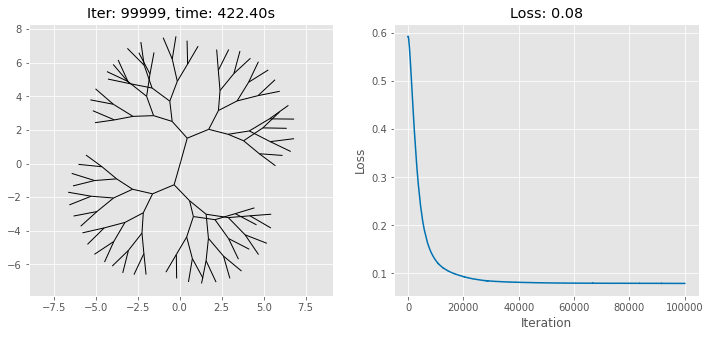

Epoch 103053: reducing learning rate of group 0 to 1.9371e-01.
Epoch 111745: reducing learning rate of group 0 to 1.7434e-01.


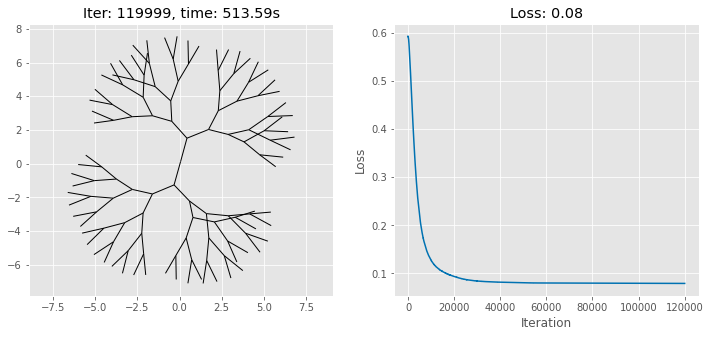

Epoch 126373: reducing learning rate of group 0 to 1.5691e-01.
Epoch 131678: reducing learning rate of group 0 to 1.4121e-01.
Epoch 133779: reducing learning rate of group 0 to 1.2709e-01.
Epoch 136135: reducing learning rate of group 0 to 1.1438e-01.
Epoch 138690: reducing learning rate of group 0 to 1.0295e-01.


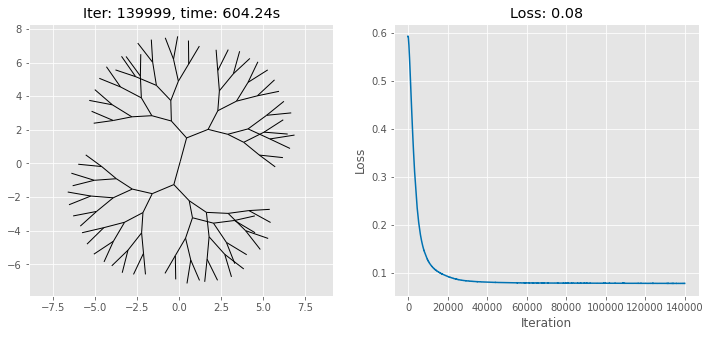

Epoch 140791: reducing learning rate of group 0 to 9.2651e-02.
Epoch 145187: reducing learning rate of group 0 to 8.3386e-02.
Epoch 148331: reducing learning rate of group 0 to 7.5047e-02.
Epoch 150890: reducing learning rate of group 0 to 6.7543e-02.
Epoch 152991: reducing learning rate of group 0 to 6.0788e-02.
Epoch 155092: reducing learning rate of group 0 to 5.4709e-02.
Epoch 158598: reducing learning rate of group 0 to 4.9239e-02.


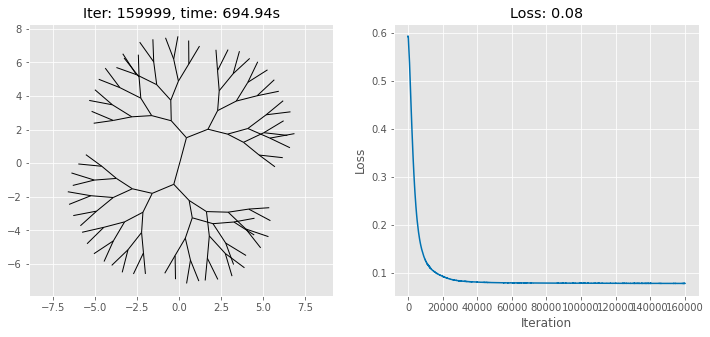

Epoch 160699: reducing learning rate of group 0 to 4.4315e-02.
Epoch 162800: reducing learning rate of group 0 to 3.9883e-02.
Epoch 164901: reducing learning rate of group 0 to 3.5895e-02.
Epoch 167002: reducing learning rate of group 0 to 3.2305e-02.
Epoch 170124: reducing learning rate of group 0 to 2.9075e-02.
Epoch 172225: reducing learning rate of group 0 to 2.6167e-02.
Epoch 174326: reducing learning rate of group 0 to 2.3551e-02.
Epoch 176427: reducing learning rate of group 0 to 2.1196e-02.
Epoch 178528: reducing learning rate of group 0 to 1.9076e-02.


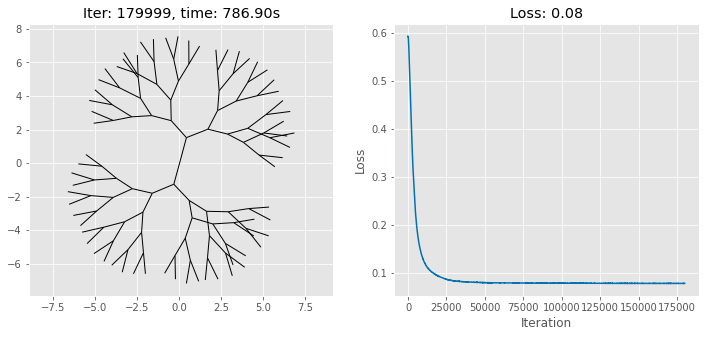

Epoch 180629: reducing learning rate of group 0 to 1.7168e-02.
Epoch 182730: reducing learning rate of group 0 to 1.5452e-02.
Epoch 184831: reducing learning rate of group 0 to 1.3906e-02.
Epoch 186932: reducing learning rate of group 0 to 1.2516e-02.
Epoch 189033: reducing learning rate of group 0 to 1.1264e-02.
Epoch 191713: reducing learning rate of group 0 to 1.0138e-02.
Epoch 193814: reducing learning rate of group 0 to 9.1240e-03.
Epoch 195915: reducing learning rate of group 0 to 8.2116e-03.
Epoch 198016: reducing learning rate of group 0 to 7.3904e-03.


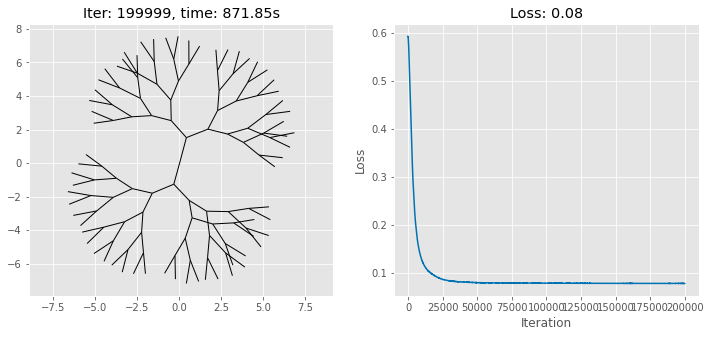

Epoch 200117: reducing learning rate of group 0 to 6.6514e-03.
Epoch 202218: reducing learning rate of group 0 to 5.9863e-03.
Epoch 204319: reducing learning rate of group 0 to 5.3876e-03.
Epoch 206420: reducing learning rate of group 0 to 4.8489e-03.
Epoch 208521: reducing learning rate of group 0 to 4.3640e-03.
Epoch 210622: reducing learning rate of group 0 to 3.9276e-03.
Epoch 212933: reducing learning rate of group 0 to 3.5348e-03.
Epoch 215034: reducing learning rate of group 0 to 3.1813e-03.
Epoch 217135: reducing learning rate of group 0 to 2.8632e-03.
Epoch 219236: reducing learning rate of group 0 to 2.5769e-03.


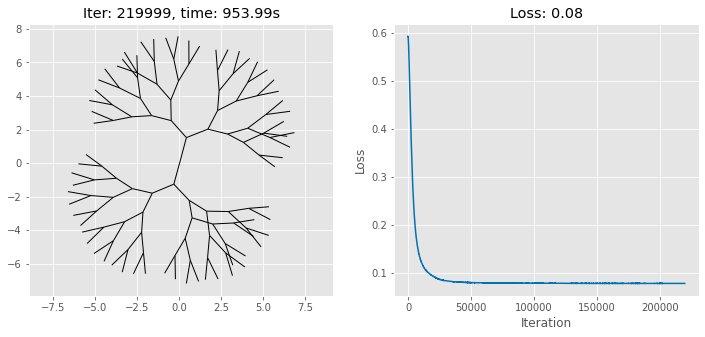

Epoch 221337: reducing learning rate of group 0 to 2.3192e-03.
Epoch 223438: reducing learning rate of group 0 to 2.0873e-03.
Epoch 225539: reducing learning rate of group 0 to 1.8786e-03.
Epoch 227640: reducing learning rate of group 0 to 1.6907e-03.
Epoch 229741: reducing learning rate of group 0 to 1.5216e-03.
Epoch 231842: reducing learning rate of group 0 to 1.3695e-03.
Epoch 235200: reducing learning rate of group 0 to 1.2325e-03.
Epoch 237301: reducing learning rate of group 0 to 1.1093e-03.
Epoch 239402: reducing learning rate of group 0 to 9.9834e-04.


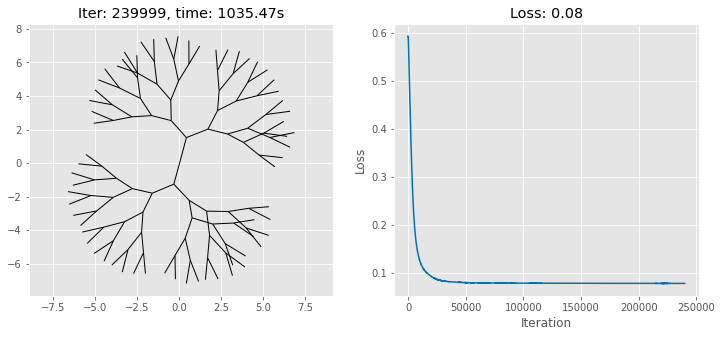

Epoch 241503: reducing learning rate of group 0 to 8.9851e-04.
Epoch 243604: reducing learning rate of group 0 to 8.0865e-04.
Epoch 245705: reducing learning rate of group 0 to 7.2779e-04.
Epoch 247806: reducing learning rate of group 0 to 6.5501e-04.
Epoch 249907: reducing learning rate of group 0 to 5.8951e-04.
Epoch 252008: reducing learning rate of group 0 to 5.3056e-04.
Epoch 254109: reducing learning rate of group 0 to 4.7750e-04.
Epoch 256777: reducing learning rate of group 0 to 4.2975e-04.
Epoch 258878: reducing learning rate of group 0 to 3.8678e-04.


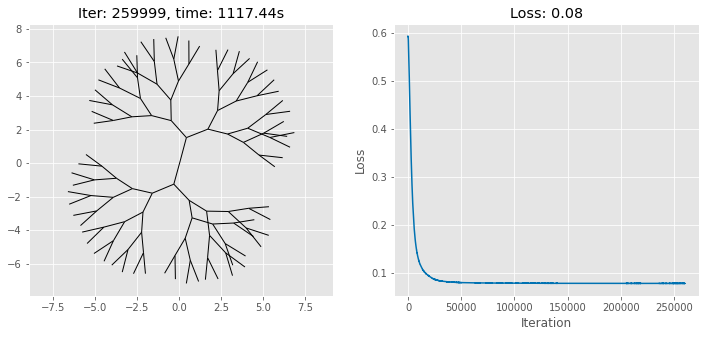

Epoch 260979: reducing learning rate of group 0 to 3.4810e-04.
Epoch 263080: reducing learning rate of group 0 to 3.1329e-04.
Epoch 265181: reducing learning rate of group 0 to 2.8196e-04.
Epoch 267282: reducing learning rate of group 0 to 2.5376e-04.
Epoch 269383: reducing learning rate of group 0 to 2.2839e-04.
Epoch 271484: reducing learning rate of group 0 to 2.0555e-04.
Epoch 273585: reducing learning rate of group 0 to 1.8499e-04.
Epoch 275686: reducing learning rate of group 0 to 1.6649e-04.
Epoch 277787: reducing learning rate of group 0 to 1.4985e-04.
Epoch 279888: reducing learning rate of group 0 to 1.3486e-04.


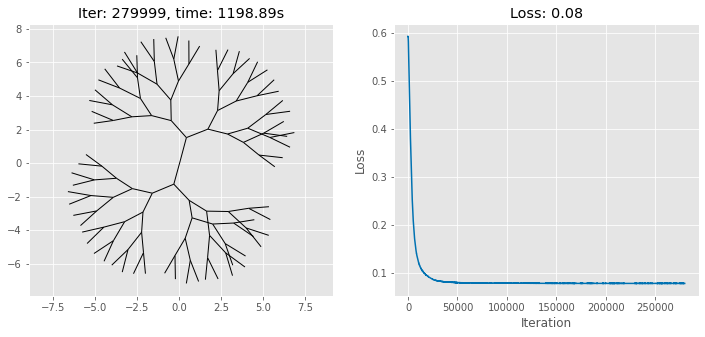

Epoch 281989: reducing learning rate of group 0 to 1.2137e-04.
Epoch 284090: reducing learning rate of group 0 to 1.0924e-04.
Epoch 286191: reducing learning rate of group 0 to 9.8314e-05.
Epoch 288292: reducing learning rate of group 0 to 8.8482e-05.
Epoch 292425: reducing learning rate of group 0 to 7.9634e-05.
Epoch 294526: reducing learning rate of group 0 to 7.1671e-05.
Epoch 296627: reducing learning rate of group 0 to 6.4504e-05.
Epoch 298728: reducing learning rate of group 0 to 5.8053e-05.


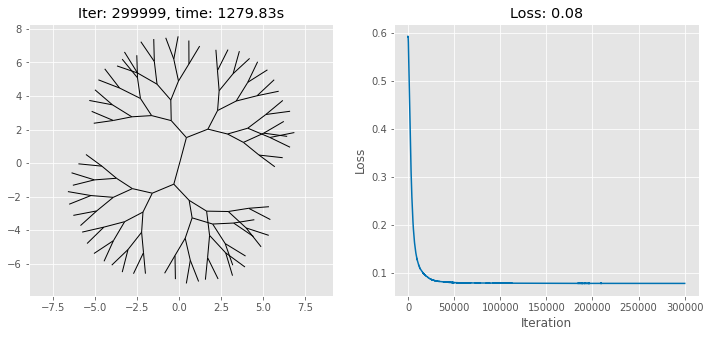

Epoch 300829: reducing learning rate of group 0 to 5.2248e-05.
Epoch 302930: reducing learning rate of group 0 to 4.7023e-05.
Epoch 305031: reducing learning rate of group 0 to 4.2321e-05.
Epoch 307132: reducing learning rate of group 0 to 3.8089e-05.
Epoch 309233: reducing learning rate of group 0 to 3.4280e-05.
Epoch 311334: reducing learning rate of group 0 to 3.0852e-05.
Epoch 313435: reducing learning rate of group 0 to 2.7767e-05.
Epoch 315536: reducing learning rate of group 0 to 2.4990e-05.
Epoch 317637: reducing learning rate of group 0 to 2.2491e-05.
Epoch 319738: reducing learning rate of group 0 to 2.0242e-05.


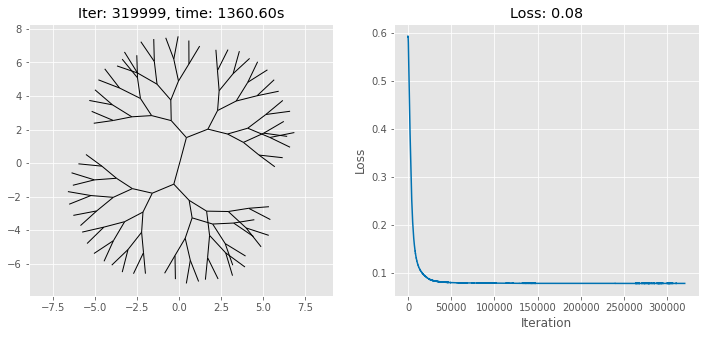

Epoch 321839: reducing learning rate of group 0 to 1.8218e-05.
Epoch 323940: reducing learning rate of group 0 to 1.6396e-05.
Epoch 326041: reducing learning rate of group 0 to 1.4756e-05.
Epoch 328142: reducing learning rate of group 0 to 1.3281e-05.
Epoch 330243: reducing learning rate of group 0 to 1.1953e-05.
Epoch 332344: reducing learning rate of group 0 to 1.0757e-05.
Epoch 334445: reducing learning rate of group 0 to 1.0000e-05.



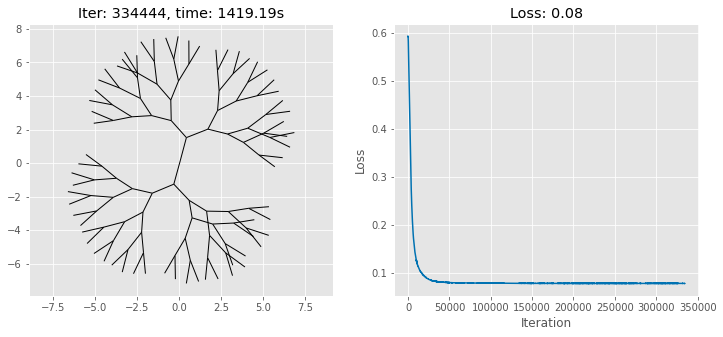


CPU times: user 56min 59s, sys: 19.9 s, total: 57min 19s
Wall time: 56min 42s


In [75]:
%%time


importlib.reload(gd2)
from gd2 import GD2
    
    
tree_depths = [6,]
sample_sizes = [1,2,4,8,16,32,64,128,256,512]
# sample_sizes = [32,64,128]
# sample_sizes = [4,]
runs = range(1)
df = pd.DataFrame()
results = []





for tree_depth, sample_size, run_number \
    in tqdm(list(itertools.product(tree_depths, sample_sizes, runs))):
    
    G = nx.balanced_tree(2, tree_depth)
    print(len(G.nodes))
    gd = GD2(G)

    result = gd.optimize(
        max_iter=int(1e7), 
        criteria_weights={
            'stress': 1,
    #         'edge_uniformity':1,
    #         'neighborhood_preservation':1,
    #         'crossings':1,
    #         'crossing_angle_maximization':1,
    #         'aspect_ratio':1,
    #         'angular_resolution':1,
    #         'vertex_resolution':1,
    #         'gabriel':1,
        }, 
        sample_sizes={
            'stress': sample_size,
    #         'edge_uniformity':1,
    #         'neighborhood_preservation':2,
    #         'crossings':1,
    #         'crossing_angle_maximization':1,
    #         'aspect_ratio':1,
    #         'angular_resolution':1,
    #         'vertex_resolution':1,
    #         'gabriel':1,
        },
#         evaluate='all',
        evaluate={'stress'},
        evaluate_interval=1000,

        vis=True,
        vis_interval=20000,

        optimizer_kwargs = dict(lr=0.5),
        scheduler_kwargs = dict(),
    )
    
    results.append(result)
    row = {
        'run': run_number,
        'tree_depth':tree_depth, 
        'sample_size':sample_size, 
        'runtime':result['runtime'],
    }
    row.update(result['qualities'])
    df = df.append(row, ignore_index=True)

    pos_G = {k:G.nodes[k]['pos'] for k in G.nodes}
    vis.plot(
        G, pos_G,
        result['loss_curve'], 
        result['iter'], result['runtime'], 
        edge=True, show=True, save=False
    )



## stress ~ time | sample_size

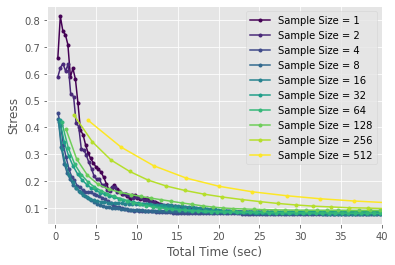

In [115]:
cm = plt.cm.get_cmap('viridis')
max_sample_size = max(sample_sizes)
for result in results:
    
    sample_size = result['sample_sizes']['stress']
    t = [x['time'] for x in result['qualities_by_time']]
    stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
    plt.plot(
        t, stress, '.-', 
        label=f'Sample Size = {sample_size}',
        color=cm(np.log(sample_size)/np.log(max_sample_size))
    )
    
plt.xlabel('Total Time (sec)')
plt.ylabel('Stress')
# plt.yscale('log')

plt.xlim([-1,40])
# plt.ylim([0,plt.ylim()[1]*1.05])
plt.legend()
plt.savefig(f'time-vs-stress-curve-by-sample-size-t{int(time.time()):d}.pdf')
plt.show()

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

# plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

In [ ]:
## Grids

In [ ]:
%%time

# grid_side_lengths = [(16,32),(16,64),(16,128)]
grid_side_lengths = [(16,32)]
sample_sizes = [4,8,16,32,64,128,256,512]
# sample_sizes = [4,]
runs = range(1)



for grid_side_length, sample_size, run_number \
    in tqdm(itertools.product(grid_side_lengths, sample_sizes, runs)):
    
    G = nx.grid_2d_graph(*grid_side_length)
    result = gd2.optimize(
        G, 
        niter=100000, 
        sample_size={'stress':sample_size}
    )
    result['qualities'] = gd2.evaluate(result)

    df = df.append({
        'run': run_number,
        'type': 'grid_2d_graph',##todo str(G), etc
        'grid_side_length': grid_side_length, 
        'num_nodes': len(G.nodes),
        'num_edges': len(G.edges),
        'sample_size':sample_size, 
        'runtime': result['runtime'],
        'stress': result['qualities']['stress']
    }, ignore_index=True)


    pos_G = {k:G.nodes[k]['pos'] for k in G.nodes}
    vis.plot(
        G, pos_G,
        result['loss_curve'], 
        result['iter'], result['runtime'], 
        edge=True, show=True, save=False
    )



In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

plt.xscale('symlog')
plt.xlabel('(Log) Runtime')

# plt.yscale('log')
plt.ylabel('Stress')


In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)